# Parametric shape optimization with differentiable FEM simulation

## Introduction

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of a signed distance field (SDF) value $g(\mathbf{x})$. For adaptive meshing, we define a sizing field $h(\mathbf{x})$ as a function of the SDF value as well.
We introduce an adpative differentiable mesher $m$ that takes the sizing field and returns a hex mesh. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field and the hex mesh as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

$$
\begin{equation}
\min_{\theta} f(m(g(\theta)), \rho(g(\theta))).
\end{equation}
$$

Here, $\theta$ is the vector of design variables.

### AD and Tesseracts

Since we want use a gradient based optimizer, we need to compute the gradient of the compliance with respect to the design variables. Hence we are interested in the following derivative:

$$
\begin{equation}
\frac{\partial f}{\partial\theta} = \frac{\partial f}{\partial \text{mesh}} \frac{\partial \text{mesh}}{\partial g} \frac{\partial g}{\partial \theta} + \frac{\partial f}{\partial \rho} \frac{\partial \rho}{\partial g} \frac{\partial g}{\partial \theta}.
\end{equation}
$$
Note that each term is a (Jacobian) matrix. With modern AD libraries such as [JAX](https://github.com/jax-ml/jax), backpropagation uses the vector-Jacobian-product to pull back the gradients over the entire pipeline, without ever materializing Jacobian matrices. This is a powerful feature, but it typically requires that the entire pipeline is implemented in a single monolithic application – which can be cumbersome and error-prone, and does not scale well to large applications or compute needs.

With Tesseracts, we wrap each function in a separate module and then compose them together. To enable differentiability, we also define AD-relevant endpoints, such as the vector-Jacobian product, inside each Tesseract module (`tesseract_api.py`).

To learn more about building and running Tesseracts, please refer to the [Tesseract documentation](https://docs.pasteurlabs.ai/projects/tesseract-core/latest/).

### Setup

Let's install the required packages and build the two Tesseract images. Building the Tesseracts can take a few minutes as they are Docker containers with quite a few dependencies.

In [1]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

## Step 1: Build + inspect used Tesseracts

In [2]:
# import tesseract_core

# tesseract_core.build_tesseract("design_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

### Explore Design Space Tesseract

First, let's import the Tesseract Core library and start a server for the design space Tesseract, which is equivalent to the function $g$ in the equation above.

In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tesseract_core import Tesseract

In [4]:
# design_tess = Tesseract.from_image("design-tube-sdf")
# design_tess.serve()
design_tess = Tesseract.from_tesseract_api("design_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [81]:
n_chains = 2
n_edges_per_chain = 2
bar_radius = 0.5

Lx = 10
Ly = 5
Lz = 5
Nx = 100
Ny = 50
Nz = 50

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    # add an offset
    print(chain / n_chains * Ly - Ly / 2)
    initial_params = initial_params.at[chain, :, 1].set(
        (chain + 1) / (n_chains + 1) * Ly - Ly / 2
    )

design_out = design_tess.apply(
    {
        "bar_params": initial_params,
        "bar_radius": bar_radius,
        "Lx": Lx,
        "Ly": Ly,
        "Lz": Lz,
        "Nx": Nx,
        "Ny": Ny,
        "Nz": Nz,
        "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

print("SDF shape:", sdf.shape)

-2.5
0.0
Number of vertices: 180
Number of faces: 352
SDF shape: (100, 50, 50)


To better understand what's going on, let's import some internal functions from the design Tesseract, and visualize the structure and its SDF field.

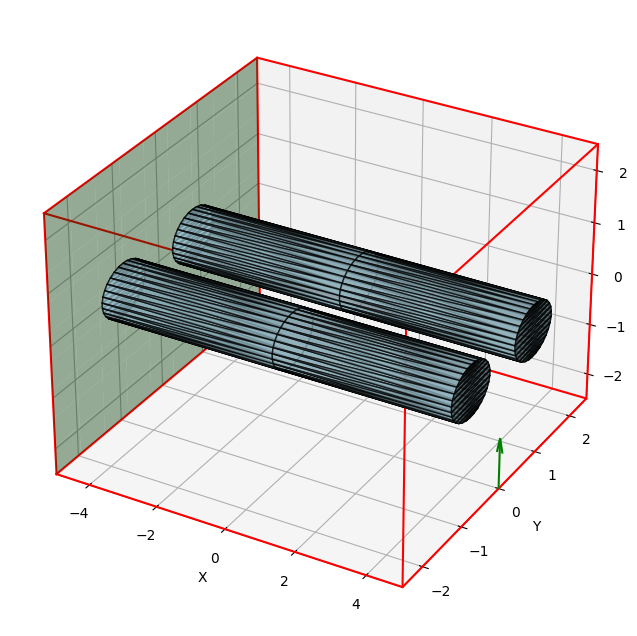

In [82]:
def plot_mesh(mesh: dict, save_path: str | None = None) -> None:
    """Plot a 3D triangular mesh with boundary conditions visualization.

    Args:
        mesh: Dictionary containing 'points' and 'faces' arrays.
        save_path: Optional path to save the plot as an image file.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(
        mesh["points"][:, 0],
        mesh["points"][:, 1],
        mesh["points"][:, 2],
        triangles=mesh["faces"],
        alpha=0.7,
        antialiased=True,
        color="lightblue",
        edgecolor="black",
    )
    # add red bounding box to indicate domain
    ax.plot(
        [-Lx / 2, Lx / 2, Lx / 2, -Lx / 2, -Lx / 2],
        [-Ly / 2, -Ly / 2, Ly / 2, Ly / 2, -Ly / 2],
        -Lz / 2 * jnp.ones(5),
        color="red",
    )
    ax.plot(
        [-Lx / 2, Lx / 2, Lx / 2, -Lx / 2, -Lx / 2],
        [-Ly / 2, -Ly / 2, Ly / 2, Ly / 2, -Ly / 2],
        Lz / 2 * jnp.ones(5),
        color="red",
    )
    ax.plot(
        [-Lx / 2, -Lx / 2],
        [-Ly / 2, -Ly / 2],
        [-Lz / 2, Lz / 2],
        color="red",
    )
    ax.plot(
        [Lx / 2, Lx / 2],
        [-Ly / 2, -Ly / 2],
        [-Lz / 2, Lz / 2],
        color="red",
    )
    ax.plot(
        [Lx / 2, Lx / 2],
        [Ly / 2, Ly / 2],
        [-Lz / 2, Lz / 2],
        color="red",
    )
    ax.plot(
        [-Lx / 2, -Lx / 2],
        [Ly / 2, Ly / 2],
        [-Lz / 2, Lz / 2],
        color="red",
    )

    # plane on x=0 to visualize dirichlet boundary
    yy, zz = jnp.meshgrid(
        jnp.linspace(-Ly / 2, Ly / 2, 10), jnp.linspace(-Ly / 2, Ly / 2, 10)
    )
    xx = -jnp.ones_like(yy) * Lx / 2
    ax.plot_surface(xx, yy, zz, alpha=0.4, color="green")

    ax.set_xlim(-Lx / 2, Lx / 2)
    ax.set_ylim(-Ly / 2, Ly / 2)
    ax.set_zlim(-Lz / 2, Lz / 2)

    # x axis label
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # green arrow on bottom right to indicate force direction
    ax.quiver(
        Lx / 2,
        0,
        -Lz / 2,
        0,
        0,
        1,
        length=1.0,
        color="green",
        arrow_length_ratio=0.3,
    )

    if save_path:
        # avoid showing the plot in notebook
        plt.savefig(save_path)
        plt.close(fig)


plot_mesh(mesh)

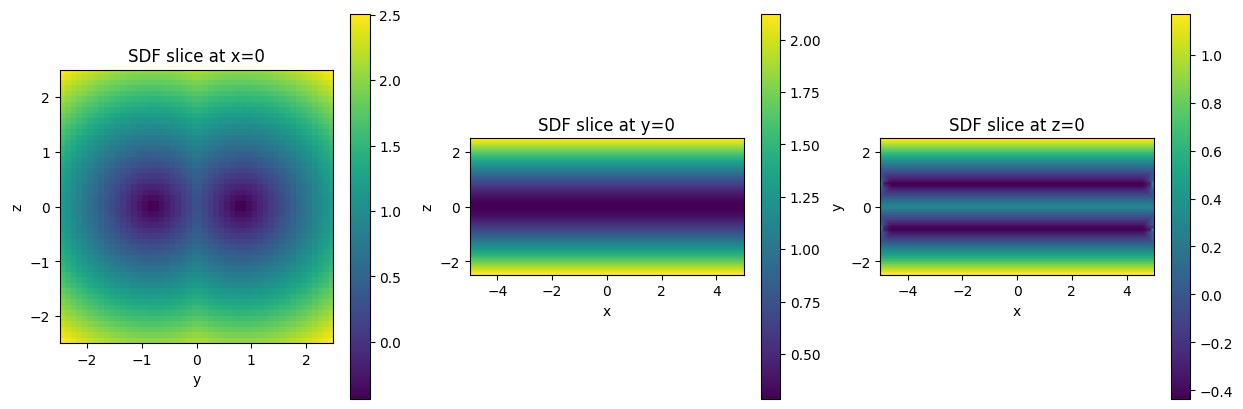

In [83]:
# visualize the sdf by plotting a slice through each axis
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(
    sdf[Nx // 2, :, :].T, extent=(-Ly / 2, Ly / 2, -Lz / 2, Lz / 2), origin="lower"
)
axs[0].set_title("SDF slice at x=0")
axs[0].set_xlabel("y")
axs[0].set_ylabel("z")
# add colorbar
plt.colorbar(
    axs[0].imshow(
        sdf[Nx // 2, :, :].T, extent=(-Ly / 2, Ly / 2, -Lz / 2, Lz / 2), origin="lower"
    ),
    ax=axs[0],
)

axs[1].imshow(
    sdf[:, Ny // 2, :].T, extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2), origin="lower"
)
axs[1].set_title("SDF slice at y=0")
axs[1].set_xlabel("x")
axs[1].set_ylabel("z")
# add colorbar
plt.colorbar(
    axs[1].imshow(
        sdf[:, Ny // 2, :].T, extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2), origin="lower"
    ),
    ax=axs[1],
)

axs[2].imshow(
    sdf[:, :, Nz // 2].T, extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2), origin="lower"
)
axs[2].set_title("SDF slice at z=0")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")

# add colorbar
plt.colorbar(
    axs[2].imshow(
        sdf[:, :, Nz // 2].T, extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2), origin="lower"
    ),
    ax=axs[2],
)

Instead of calling the apply endpoint we can also call the vector-Jacobian product endpoint which is used for backpropagation (also called reverse-mode AD). This endpoint computes the derivative of the SDF with respect to the design variables, which is useful for gradient-based optimization. Hence we set the `vjp_inputs` to `bar_params` and the `vjp_outputs` to `sdf`, to indicate that we want to differentiate the SDF with respect to the shape parameters. 

In [84]:
grad = design_tess.vector_jacobian_product(
    inputs={
        "bar_params": initial_params,
        "bar_radius": bar_radius,
        "Lx": Lx,
        "Ly": Ly,
        "Lz": Nz,
        "Nx": Nx,
        "Ny": Ny,
        "Nz": Nz,
        "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
        "normalize_jacobian": True,
        "normalize_vjp": False,
    },
    vjp_inputs=["bar_params"],
    vjp_outputs=["sdf"],
    cotangent_vector={"sdf": jnp.ones((Nx, Ny, Nz), dtype=jnp.float32)},
)["bar_params"]

print("Gradient shape:", grad.shape)
print(grad.std())

Gradient shape: (2, 3, 3)
0.006493404


Above we manually supplied all the relevant information regarding the VJP inputs, outputs, and cotangent vector. To make this easier, we can use the [Tesseract-JAX](https://github.com/pasteurlabs/tesseract-jax) library. Tesseract-JAX automatically registers Tesseracts as JAX primitives, which allows us to use JAX as an AD engine over functions that mix and match Tesseracts with regular JAX code. We can see this in action by using the `jax.vjp` function over `tesseract_jax.apply_tesseract`.

In [85]:
import jax
from tesseract_jax import apply_tesseract

primal, vjp_fun = jax.vjp(
    lambda params: apply_tesseract(
        design_tess,
        {
            "bar_params": params,
            "bar_radius": bar_radius,
            "Lx": Lx,
            "Ly": Ly,
            "Lz": Lz,
            "Nx": Nx,
            "Ny": Ny,
            "Nz": Nz,
            "epsilon": 0.01,  # Smoothing parameter for SDF computation,
            "normalize_jacobian": True,
        },
    )["sdf"],
    initial_params,
)

grad = vjp_fun(jnp.ones((Nx, Ny, Nz), dtype=jnp.float32))[0]

print("Gradient shape:", grad.shape)

Gradient shape: (2, 3, 3)


In [86]:
# Lets figure out a good epsilon value for FD jacobian computation
epsilons = jnp.logspace(-6, 0, 6)
mean_grads = []
std_grads = []

for i in range(len(epsilons)):
    eps = epsilons[i]
    primal, vjp_fun = jax.vjp(
        lambda params, eps=eps: apply_tesseract(
            design_tess,
            {
                "bar_params": params,
                "bar_radius": bar_radius,
                "Lx": Lx,
                "Ly": Ly,
                "Lz": Lz,
                "Nx": Nx,
                "Ny": Ny,
                "Nz": Nz,
                "epsilon": eps.item(),  # Smoothing parameter for SDF computation,
                "normalize_jacobian": True,
            },
        )["sdf"],
        initial_params,
    )

    grad = vjp_fun(jnp.ones((Nx, Ny, Nz), dtype=jnp.float32))[0]

    mean_grads.append(jnp.mean(jnp.abs(grad)))
    std_grads.append(jnp.std(grad))

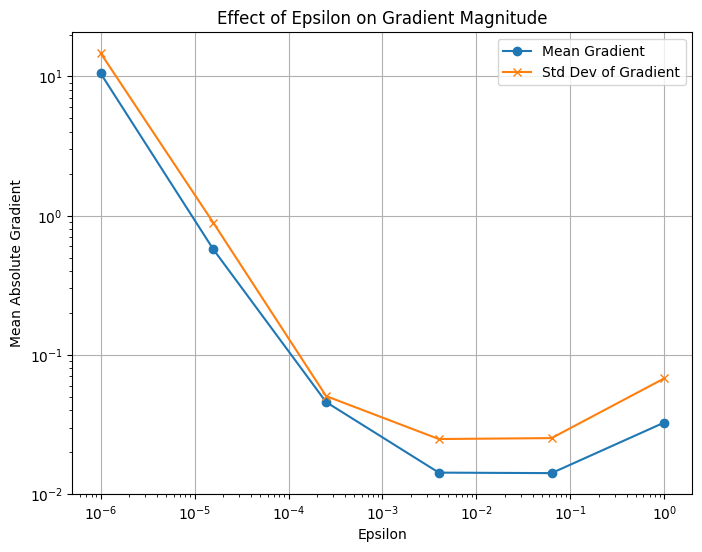

In [87]:
plt.figure(figsize=(8, 6))
plt.plot(epsilons, mean_grads, marker="o")
plt.plot(epsilons, std_grads, marker="x")
plt.xlabel("Epsilon")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Mean Absolute Gradient")
plt.title("Effect of Epsilon on Gradient Magnitude")
plt.grid(True)
plt.legend(["Mean Gradient", "Std Dev of Gradient"])

### Define mapping from SDF to Density Field

Now that we have the signed distance field (SDF) from the design space, we can proceed to compute the *density field*, which is what the FEM solver expects. That is, we need to define a function $\rho$ that maps the SDF to a density value. This function needs to be smooth and differentiable to ensure that the optimization process can effectively navigate the design space. We use a parametrized sigmoid function, which ensures that the density values are bounded between 0 and 1. Here, $s$ is the slope of the sigmoid and $\varepsilon$ is the offset. The parameters $s$ and $\varepsilon$ can be adjusted to control the steepness and position of the transition between 0 and 1 in the density field.

$$
\begin{equation}
    \rho(\text{SDF}) = \frac{1}{1 + e^{s \cdot \text{SDF} - \varepsilon}}
\end{equation}
$$

Since this function is straightforward to implement, we can directly use the JAX library to define it.

In [88]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 6.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))

To verify the conversion, we can visualize the density field:

Rho shape: (100, 50, 50)
Rho min/max: 3.2785982e-07 0.93798834


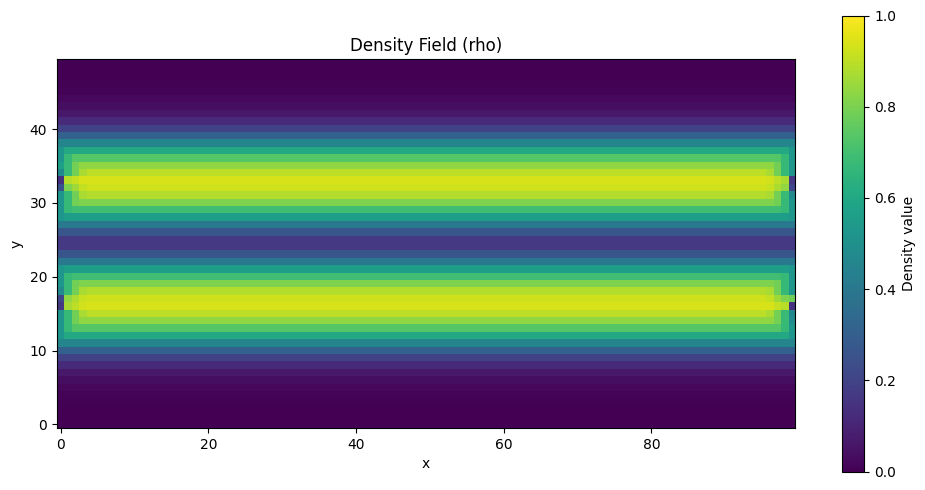

In [89]:
rho = sdf_to_rho(sdf)
print("Rho shape:", rho.shape)
print("Rho min/max:", jnp.min(rho), jnp.max(rho))
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(rho[:, :, Nz // 2].T, origin="lower", cmap="viridis", vmin=0, vmax=1)
ax.set_title("Density Field (rho)")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(im, ax=ax, label="Density value")
plt.tight_layout()

In [90]:
def sizing_field(
    sdf: jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 10.0
) -> jnp.ndarray:
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.

    Returns:
        Sizing field values.
    """

    def gauss(x: jnp.ndarray, mu: float, sigma: float) -> jnp.ndarray:
        return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    normalized_sdf = 1 - gauss(sdf, 0.0, 1.0 / scale)
    return min_size + (max_size - min_size) * normalized_sdf

Sizing field: min 0.25, max 1.6666666269302368, mean 1.4966239929199219
Sizing field shape: (100, 50, 50)


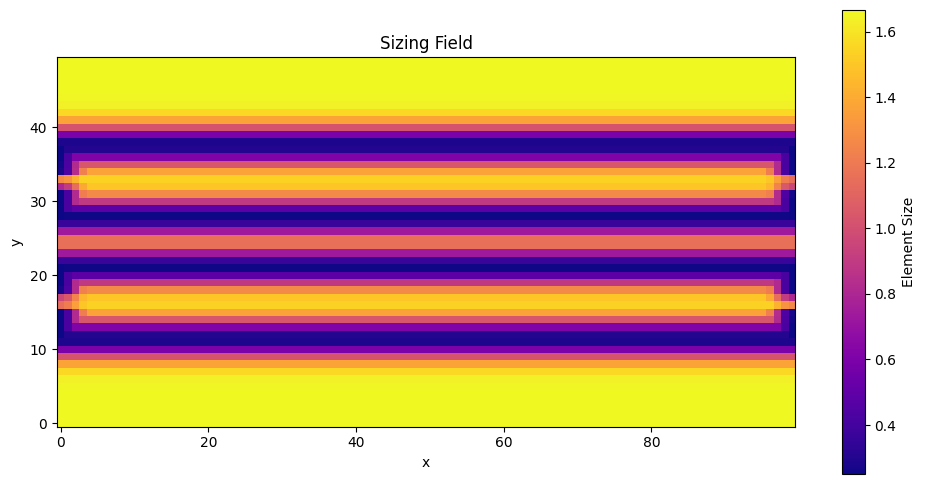

In [91]:
sizing = sizing_field(sdf, min_size=Lx / 40, max_size=Lx / 6, scale=5.0)
print(f"Sizing field: min {sizing.min()}, max {sizing.max()}, mean {sizing.mean()}")
print("Sizing field shape:", sizing.shape)
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(sizing[:, :, Nz // 2].T, origin="lower", cmap="plasma")
ax.set_title("Sizing Field")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(im, ax=ax, label="Element Size")
plt.tight_layout()

In [93]:
mesher = Tesseract.from_tesseract_api("meshing_tess/tesseract_api.py")

mesher_out = apply_tesseract(
    mesher,
    {
        "Lx": Lx,
        "Ly": Ly,
        "Lz": Lz,
        "sizing_field": sizing,
        "field_values": rho,
        "max_subdivision_levels": 4,
        "max_points": 10000,
        "max_cells": 10000,
    },
)
print(
    f"Mesh points: {mesher_out['mesh']['n_points']}, Mesh faces: {mesher_out['mesh']['n_faces']}"
)


Mesh points: 1645, Mesh faces: 1184


In [94]:
max_cells = 15000
primal, vjp_fun = jax.vjp(
    lambda rho: apply_tesseract(
        mesher,
        {
            "Lx": Lx,
            "Ly": Ly,
            "Lz": Lz,
            "sizing_field": sizing,
            "field_values": rho,
            "max_subdivision_levels": 4,
            "max_points": 20000,
            "max_cells": max_cells,
        },
    )["mesh_cell_values"],
    rho,
)
grad = vjp_fun(jnp.ones((max_cells,), dtype=jnp.float32))[0]
print("Gradient shape:", grad.shape)

Gradient shape: (100, 50, 50)


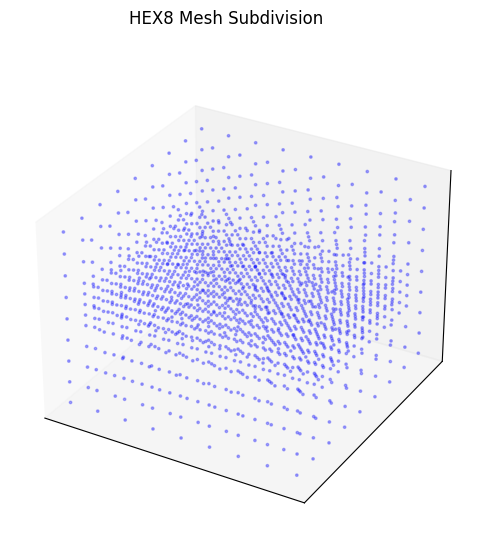

In [95]:
def plot_hex8_mesh(
    pts_coords: jnp.ndarray,  # (n_points, 3)
    hex_cells: jnp.ndarray,  # (n_hex, 8)
    ax,  # noqa: ANN001
    plot_cells: bool = True,
) -> None:
    """Plot hexahedral mesh with optional cell edges.

    Args:
        pts_coords: Array of point coordinates, shape (n_points, 3).
        hex_cells: Array of hexahedral cell connectivity, shape (n_hex, 8).
        ax: Matplotlib 3D axis object for plotting.
        plot_cells: Whether to plot cell edges.
    """
    ax.scatter(
        pts_coords[:, 0],
        pts_coords[:, 1],
        pts_coords[:, 2],
        color="blue",
        s=3,
        alpha=0.3,
    )

    # # Plot hex cells
    if plot_cells:
        for cell in hex_cells:
            # Get the coordinates of the cell's corners
            corners = pts_coords[cell]
            # print(f"Cells {cell}: Corners {corners}")
            for corner in [
                (0, 1),
                (1, 2),
                (2, 3),
                (3, 0),  # bottom face
                (4, 5),
                (5, 6),
                (6, 7),
                (7, 4),  # top face
                (0, 4),
                (1, 5),
                (2, 6),
                (3, 7),  # vertical edges
            ]:
                hexagon = [corners[corner[0]], corners[corner[1]]]
                ax.plot3D(
                    *zip(*hexagon, strict=True), color="red", linewidth=1, alpha=0.5
                )


fig, axs = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(12, 6))
plt.suptitle("HEX8 Mesh Subdivision")
# remove the axis ticks
axs.set_xticks([])
axs.set_yticks([])
axs.set_zticks([])
# remove the grid
axs.grid(False)

pts = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]
plot_hex8_mesh(pts, hex_cells, ax=axs, plot_cells=False)

In [96]:
# Lets export it to a .vtk using pyvista
import numpy as np
import pyvista as pv


def hex_to_pyvista(pts: np.ndarray, faces: np.ndarray) -> pv.UnstructuredGrid:
    """Convert hex mesh defined by points and faces into a PyVista UnstructuredGrid.

    Args:
        pts: Array of point coordinates, shape (N, 3).
        faces: Array of hexahedral cell connectivity, shape (M, 8).

    Returns:
        PyVista mesh representing the hexahedral grid.
    """
    # Define the cell type for hexahedrons (VTK_HEXAHEDRON = 12)
    cell_type = pv.CellType.HEXAHEDRON
    cell_types = np.array([cell_type] * faces.shape[0], dtype=np.uint8)

    # Prepare the cells array: [number_of_points, i0, i1, i2, i3, i4, i5, i6, i7]
    n_cells = faces.shape[0]
    cells = np.empty((n_cells, 9), dtype=np.int64)
    cells[:, 0] = 8  # Each cell has 8 points
    cells[:, 1:9] = faces

    # Flatten the cells array for PyVista
    cells = cells.flatten()

    return pv.UnstructuredGrid(cells, cell_types, pts)


# convert arrays to numpy
pts_np = np.array(pts)
cells_np = np.array(hex_cells)

hex_mesh = hex_to_pyvista(pts_np, cells_np)

print(hex_mesh)

hex_mesh.save("fem_shapeopt_mesh.vtk")

UnstructuredGrid (0x7ddc67030ac0)
  N Cells:    1184
  N Points:   1645
  X Bounds:   -5.000e+00, 5.000e+00
  Y Bounds:   -2.500e+00, 2.500e+00
  Z Bounds:   -2.500e+00, 2.500e+00
  N Arrays:   0


### FEM Tesseract

Now that we have a density field, we compute the *compliance* of the structure (~stiffness against deformation). That is, we find the most stable configuration of the structure under a given load. The compliance is computed using a finite element method (FEM) solver, which is implemented in the FEM Tesseract. The FEM Tesseract takes the density field as input and returns the compliance of the structure.

The compliance Tesseract is using the jax-fem finite element library, which is fully auto-differentiable. Inside the Tesseract the boundary conditions are already hard coded, where the entire left side is subject to a Dirichlet boundary condition and bottom right side to a Neumann boundary condition.

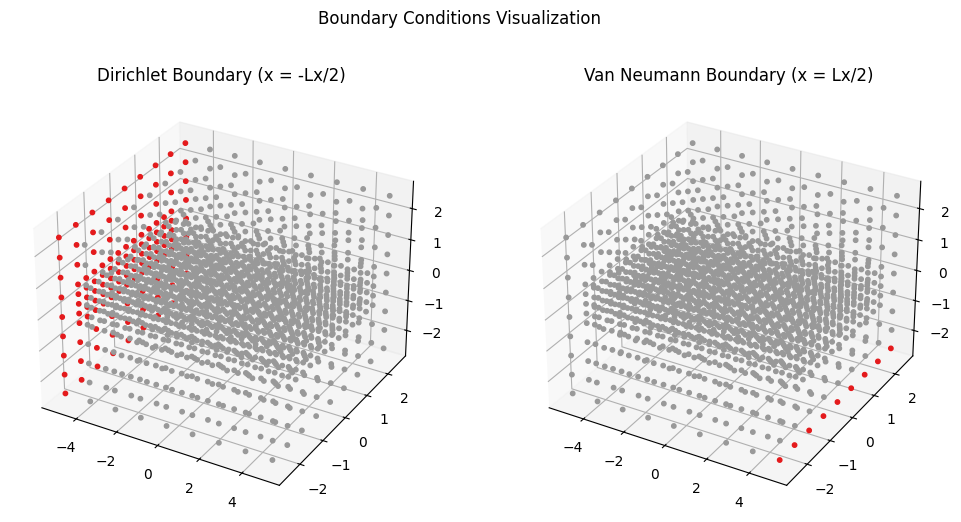

In [97]:
# Lets setup the boundary conditions

dirichlet_mask = pts[:, 0] <= -Lx / 2 + 1e-5
van_neumann_mask = jnp.logical_and(
    jnp.isclose(pts[:, 0], Lx / 2, atol=0.1),
    jnp.isclose(pts[:, 2], -Lz / 2, atol=0.1),
)


fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions Visualization")
# remove the axis ticks
colors = jnp.where(dirichlet_mask, 0.1, 0.2)

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=colors,
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask, 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

In [98]:
# fem_tess = Tesseract.from_image("structure-jax-fem")
# fem_tess.serve()
fem_tess = Tesseract.from_tesseract_api("fem_tess/tesseract_api.py")

In [99]:
compliance = apply_tesseract(
    fem_tess,
    {
        # unsqueeze rho to 1D array
        "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
        # "rho" : rho.reshape(Nx*Ny*Nz, 1),
        "Lx": Lx,
        "Ly": Ly,
        "Lz": Lz,
        "Nx": Nx,
        "Ny": Ny,
        "Nz": Nz,
        "hex_mesh": mesher_out["mesh"],
        "use_regular_grid": False,
        "dirichlet_mask": dirichlet_mask,
        "dirichlet_values": jnp.array([0.0]),
        "van_neumann_mask": van_neumann_mask,
        "van_neumann_values": jnp.array([[0.0, 0.0, 10.0]]),
    },
)["compliance"]
print(f"Compliance: {compliance:.4f}")

[11-04 16:34:50][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:34:50][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:34:50][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:34:51][DEBUG] jax_fem: Done pre-computations, took 0.9195077419281006 [s]
[11-04 16:34:51][INFO] jax_fem: Solving a problem with 1184 cells, 1645x3 = 4935 dofs.
[11-04 16:34:51][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 1184 elements.
(1184, 1)


[11-04 16:34:53][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:34:53][DEBUG] jax_fem: Start timing
[11-04 16:34:54][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:34:54][DEBUG] jax_fem: Function split_and_compute_cell took 0.5486 seconds
[11-04 16:34:56][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:34:56][DEBUG] jax_fem: Before, l_2 res = 130.86028596931058, relative l_2 res = 1.0
[11-04 16:34:56][DEBUG] jax_fem: Solving linear system...
[11-04 16:34:56][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:34:56][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:34:56][DEBUG] jax_fem: Function split_and_compute_cell took 0.0198 seconds
[11-04 16:34:56][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (22794,), indices shape = (22794,), indptr shape = (4936,), b shape = (4935,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:34:56][DEBUG] jax_fem: l_2 res = 3.939425676055883e-13, relative l_2 res = 3.0104058285336156e-15
[11-04 16:34:57][INFO] jax_fem: Solve took 3.098804235458374 [s]
[11-04 16:34:57][INFO] jax_fem: max of dofs = 0.9350113207375988
[11-04 16:34:57][INFO] jax_fem: min of dofs = -2.223474368276938


Compliance: 1527.1154


## Step 2: Gradient-based parametric shape optimization

Now that we have all the components of the pipeline, we can compose them together and define the loss function for the optimization. The loss function is simply the compliance of the structure, which we can compute by applying the FEM Tesseract to the density field obtained from the design space Tesseract.

**This function looks trivial, but it is actually a complex pipeline that involves several components, each of which is differentiable.** The complexity is hidden behind the Tesseract implementation, which allows us to compose the components together and use them as a single function, without worrying about the details of the implementation.

In [100]:
from typing import TypeVar
T = TypeVar("T")

def stop_gradient_(x: T) -> T:
  """Stops gradient computation.

  We cannot use jax.lax.stop_gradient directly because Tesseract meshes are
  nested dictionaries with arrays and integers, and jax.lax.stop_gradient
  does not support integers.
    Args:
        x: Input value.
    Returns:
        Value with stopped gradients.
"""

  def stop(x):
    return jax._src.ad_util.stop_gradient_p.bind(x)

  return jax.tree_util.tree_map(stop, x)

def loss(
        
    params: jnp.ndarray,
    van_neumann_mask: jnp.ndarray,
    dirichlet_mask: jnp.ndarray,
    ) -> float:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # -- Tess 1 (design) --
    # Generate signed distance field from design parameters
    sdf = apply_tesseract(
        design_tess,
        {
            "bar_params": params,
            "bar_radius": bar_radius,
            "Lx": Lx,
            "Ly": Ly,
            "Lz": Lz,
            "Nx": Nx,
            "Ny": Ny,
            "Nz": Nz,
            "epsilon": 1e-2,  # epsilon for finite difference
            "normalize_jacobian": True,
        },
    )["sdf"]

    # -- Local JAX code --
    # Convert SDF to material density distribution
    rho = sdf_to_rho(sdf)

    sizing = sizing_field(sdf, min_size=Lx / 40, max_size=Lx / 6, scale=5.0)

    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "Lx": Lx,
            "Ly": Ly,
            "Lz": Lz,
            "sizing_field": sizing,
            "field_values": rho,
            "max_subdivision_levels": 5,
            "max_points": 10000,
            "max_cells": 10000,
        },
    )

    mesh = stop_gradient_(mesher_out["mesh"])

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, 10.0]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
            fem_tess,
            {
                "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
                "dirichlet_mask": dirichlet_mask,
                "dirichlet_values": dirichlet_values,
                "van_neumann_mask": van_neumann_mask,
                "van_neumann_values": van_neumann_values,
                "hex_mesh": mesh,
                "Lx": Lx,
                "Ly": Ly,
                "Lz": Lz,
                "Nx": Nx,
                "Ny": Ny,
                "Nz": Nz,
                "use_regular_grid": False,
            },
        )["compliance"]


    return c

Now we can use JAX's `grad` function to compute the gradient of the compliance with respect to the design variables. We use a simple gradient descent optimizer to perform the optimization towards a local minimum. This is not a very sophisticated optimization approach, but it serves as a good starting point. The optimization process will take a few minutes to run.

In [102]:
import optax

optmizer = optax.adam(learning_rate=0.02)
opt_state = optmizer.init(initial_params)

params = initial_params.copy()
loss_hist = []
params_hist = []

grad_fn = jax.value_and_grad(loss)

for i in range(50):
    loss_value, grads = grad_fn(params, van_neumann_mask, dirichlet_mask)

    updates, opt_state = optmizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)

    # Ensure parameters are within bounds
    params = params.at[..., 1].set(
        jnp.clip(params[..., 1], -Ly / 2 + bar_radius, Ly / 2 - bar_radius)
    )

    # Clip the z-coordinates to be within the bar radius
    params = params.at[..., 2].set(
        jnp.clip(params[..., 2], -Lz / 2 + bar_radius, Lz / 2 - bar_radius)
    )

    loss_hist.append(loss_value)
    params_hist.append(params)

    print(f"Iteration {i + 1}, Loss: {loss_value:.2f}")

[11-04 16:36:37][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:36:37][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:36:37][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:36:37][DEBUG] jax_fem: Done pre-computations, took 0.6360824108123779 [s]
[11-04 16:36:37][INFO] jax_fem: Solving a problem with 3424 cells, 5121x3 = 15363 dofs.
[11-04 16:36:37][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 16:36:39][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:36:39][DEBUG] jax_fem: Start timing
[11-04 16:36:39][DEBUG] jax_fem: Computing cell Jacobian and cell residual...


Setup completed with mesh of 3424 elements.
(3424, 1)


[11-04 16:36:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.4072 seconds
[11-04 16:36:40][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:36:40][DEBUG] jax_fem: Before, l_2 res = 96.63717703192317, relative l_2 res = 1.0
[11-04 16:36:40][DEBUG] jax_fem: Solving linear system...
[11-04 16:36:40][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:36:40][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:36:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.0460 seconds
[11-04 16:36:40][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33546,), indices shape = (33546,), indptr shape = (15364,), b shape = (15363,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:36:41][DEBUG] jax_fem: l_2 res = 2.047406853443393e-13, relative l_2 res = 2.118653417169928e-15
[11-04 16:36:41][INFO] jax_fem: Solve took 1.4616215229034424 [s]
[11-04 16:36:41][INFO] jax_fem: max of dofs = 0.9571990951695749
[11-04 16:36:41][INFO] jax_fem: min of dofs = -2.2763869180264815
[11-04 16:36:43][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:36:43][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:36:43][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:36:43][DEBUG] jax_fem: Done pre-computations, took 0.6100189685821533 [s]
[11-04 16:36:43][INFO] jax_fem: Solving a problem with 3424 cells, 5121x3 = 15363 dofs.
[11-04 16:36:43][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 16:36:45][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:36:45][DEBUG] jax_fem: Start timing
[11-04 16:36:4

Setup completed with mesh of 3424 elements.
(3424, 1)


[11-04 16:36:45][DEBUG] jax_fem: Function split_and_compute_cell took 0.3887 seconds
[11-04 16:36:46][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:36:46][DEBUG] jax_fem: Before, l_2 res = 96.63717703192317, relative l_2 res = 1.0
[11-04 16:36:46][DEBUG] jax_fem: Solving linear system...
[11-04 16:36:46][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:36:46][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:36:46][DEBUG] jax_fem: Function split_and_compute_cell took 0.0365 seconds
[11-04 16:36:46][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33546,), indices shape = (33546,), indptr shape = (15364,), b shape = (15363,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:36:46][DEBUG] jax_fem: l_2 res = 2.047406853443393e-13, relative l_2 res = 2.118653417169928e-15
[11-04 16:36:46][INFO] jax_fem: Solve took 1.3570334911346436 [s]
[11-04 16:36:46][INFO] jax_fem: max of dofs = 0.9571990951695749
[11-04 16:36:46][INFO] jax_fem: min of dofs = -2.2763869180264815
[11-04 16:36:48][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:36:48][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:36:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.0332 seconds
[11-04 16:36:48][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:36:49][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:36:49][DEBUG] jax_fem: Computing cell residual...


cpu
data shape = (33546,), indices shape = (33546,), indptr shape = (15364,), b shape = (15363,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:36:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.3472 seconds


Iteration 1, Loss: 816.03


[11-04 16:37:02][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:37:02][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:37:02][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:37:04][DEBUG] jax_fem: Done pre-computations, took 1.3600070476531982 [s]
[11-04 16:37:04][INFO] jax_fem: Solving a problem with 3277 cells, 4946x3 = 14838 dofs.
[11-04 16:37:04][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3277 elements.
(3277, 1)


[11-04 16:37:07][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:37:07][DEBUG] jax_fem: Start timing
[11-04 16:37:08][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:37:08][DEBUG] jax_fem: Function split_and_compute_cell took 0.5449 seconds
[11-04 16:37:10][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:37:10][DEBUG] jax_fem: Before, l_2 res = 96.63717703192316, relative l_2 res = 1.0
[11-04 16:37:10][DEBUG] jax_fem: Solving linear system...
[11-04 16:37:10][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:37:10][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:37:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.0388 seconds
[11-04 16:37:11][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33021,), indices shape = (33021,), indptr shape = (14839,), b shape = (14838,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:37:11][DEBUG] jax_fem: l_2 res = 1.758447164862047e-13, relative l_2 res = 1.8196383823185987e-15
[11-04 16:37:11][INFO] jax_fem: Solve took 3.540022373199463 [s]
[11-04 16:37:11][INFO] jax_fem: max of dofs = 0.9408012578050927
[11-04 16:37:11][INFO] jax_fem: min of dofs = -2.2784910411303168
[11-04 16:37:13][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:37:13][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:37:13][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:37:15][DEBUG] jax_fem: Done pre-computations, took 1.5175940990447998 [s]
[11-04 16:37:15][INFO] jax_fem: Solving a problem with 3277 cells, 4946x3 = 14838 dofs.
[11-04 16:37:15][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3277 elements.
(3277, 1)


[11-04 16:37:19][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:37:19][DEBUG] jax_fem: Start timing
[11-04 16:37:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:37:19][DEBUG] jax_fem: Function split_and_compute_cell took 0.5409 seconds
[11-04 16:37:21][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:37:21][DEBUG] jax_fem: Before, l_2 res = 96.63717703192316, relative l_2 res = 1.0
[11-04 16:37:21][DEBUG] jax_fem: Solving linear system...
[11-04 16:37:21][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:37:22][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:37:22][DEBUG] jax_fem: Function split_and_compute_cell took 0.0307 seconds
[11-04 16:37:22][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33021,), indices shape = (33021,), indptr shape = (14839,), b shape = (14838,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:37:22][DEBUG] jax_fem: l_2 res = 1.758447164862047e-13, relative l_2 res = 1.8196383823185987e-15
[11-04 16:37:22][INFO] jax_fem: Solve took 3.488823413848877 [s]
[11-04 16:37:22][INFO] jax_fem: max of dofs = 0.9408012578050927
[11-04 16:37:22][INFO] jax_fem: min of dofs = -2.2784910411303168
[11-04 16:37:25][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:37:25][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:37:25][DEBUG] jax_fem: Function split_and_compute_cell took 0.0308 seconds
[11-04 16:37:25][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:37:25][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (33021,), indices shape = (33021,), indptr shape = (14839,), b shape = (14838,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:37:26][DEBUG] jax_fem: Computing cell residual...
[11-04 16:37:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.4678 seconds


Iteration 2, Loss: 804.68


[11-04 16:37:51][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:37:51][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:37:51][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:37:52][DEBUG] jax_fem: Done pre-computations, took 1.3857941627502441 [s]
[11-04 16:37:52][INFO] jax_fem: Solving a problem with 3256 cells, 4885x3 = 14655 dofs.
[11-04 16:37:52][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3256 elements.
(3256, 1)


[11-04 16:37:56][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:37:56][DEBUG] jax_fem: Start timing
[11-04 16:37:56][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:37:56][DEBUG] jax_fem: Function split_and_compute_cell took 0.4919 seconds
[11-04 16:37:58][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:37:58][DEBUG] jax_fem: Before, l_2 res = 96.49250907433589, relative l_2 res = 1.0
[11-04 16:37:58][DEBUG] jax_fem: Solving linear system...
[11-04 16:37:58][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:37:59][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:37:59][DEBUG] jax_fem: Function split_and_compute_cell took 0.0374 seconds
[11-04 16:37:59][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32820,), indices shape = (32820,), indptr shape = (14656,), b shape = (14655,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:37:59][DEBUG] jax_fem: l_2 res = 2.2481745772707618e-13, relative l_2 res = 2.329895448711789e-15
[11-04 16:37:59][INFO] jax_fem: Solve took 3.526244640350342 [s]
[11-04 16:37:59][INFO] jax_fem: max of dofs = 0.926446579491879
[11-04 16:37:59][INFO] jax_fem: min of dofs = -2.2755912246771377
[11-04 16:38:01][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:38:01][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:38:01][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:38:03][DEBUG] jax_fem: Done pre-computations, took 1.55104398727417 [s]
[11-04 16:38:03][INFO] jax_fem: Solving a problem with 3256 cells, 4885x3 = 14655 dofs.
[11-04 16:38:03][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3256 elements.
(3256, 1)


[11-04 16:38:07][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:38:07][DEBUG] jax_fem: Start timing
[11-04 16:38:07][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:38:08][DEBUG] jax_fem: Function split_and_compute_cell took 0.5079 seconds
[11-04 16:38:09][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:38:10][DEBUG] jax_fem: Before, l_2 res = 96.49250907433589, relative l_2 res = 1.0
[11-04 16:38:10][DEBUG] jax_fem: Solving linear system...
[11-04 16:38:10][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:38:10][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:38:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.0326 seconds
[11-04 16:38:10][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32820,), indices shape = (32820,), indptr shape = (14656,), b shape = (14655,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:38:10][DEBUG] jax_fem: l_2 res = 2.2481745772707618e-13, relative l_2 res = 2.329895448711789e-15
[11-04 16:38:10][INFO] jax_fem: Solve took 3.605653762817383 [s]
[11-04 16:38:10][INFO] jax_fem: max of dofs = 0.926446579491879
[11-04 16:38:10][INFO] jax_fem: min of dofs = -2.2755912246771377
[11-04 16:38:13][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:38:13][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:38:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.0322 seconds
[11-04 16:38:13][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:38:13][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32820,), indices shape = (32820,), indptr shape = (14656,), b shape = (14655,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:38:14][DEBUG] jax_fem: Computing cell residual...
[11-04 16:38:14][DEBUG] jax_fem: Function split_and_compute_cell took 0.4608 seconds


Iteration 3, Loss: 793.81


[11-04 16:38:32][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:38:32][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:38:32][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:38:33][DEBUG] jax_fem: Done pre-computations, took 1.4015722274780273 [s]
[11-04 16:38:33][INFO] jax_fem: Solving a problem with 3249 cells, 4939x3 = 14817 dofs.
[11-04 16:38:33][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3249 elements.
(3249, 1)


[11-04 16:38:37][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:38:37][DEBUG] jax_fem: Start timing
[11-04 16:38:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:38:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.5143 seconds
[11-04 16:38:39][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:38:39][DEBUG] jax_fem: Before, l_2 res = 96.5909068597192, relative l_2 res = 1.0
[11-04 16:38:39][DEBUG] jax_fem: Solving linear system...
[11-04 16:38:40][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:38:40][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:38:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.0368 seconds
[11-04 16:38:40][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33045,), indices shape = (33045,), indptr shape = (14818,), b shape = (14817,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:38:40][DEBUG] jax_fem: l_2 res = 1.5953068187842123e-13, relative l_2 res = 1.6516118034807423e-15
[11-04 16:38:40][INFO] jax_fem: Solve took 3.6004817485809326 [s]
[11-04 16:38:40][INFO] jax_fem: max of dofs = 0.9096560910384903
[11-04 16:38:40][INFO] jax_fem: min of dofs = -2.269967389165872
[11-04 16:38:42][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:38:42][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:38:42][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:38:44][DEBUG] jax_fem: Done pre-computations, took 1.5345971584320068 [s]
[11-04 16:38:44][INFO] jax_fem: Solving a problem with 3249 cells, 4939x3 = 14817 dofs.
[11-04 16:38:44][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3249 elements.
(3249, 1)


[11-04 16:38:48][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:38:48][DEBUG] jax_fem: Start timing
[11-04 16:38:48][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:38:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.5153 seconds
[11-04 16:38:50][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:38:51][DEBUG] jax_fem: Before, l_2 res = 96.5909068597192, relative l_2 res = 1.0
[11-04 16:38:51][DEBUG] jax_fem: Solving linear system...
[11-04 16:38:51][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:38:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:38:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.0338 seconds
[11-04 16:38:51][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33045,), indices shape = (33045,), indptr shape = (14818,), b shape = (14817,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:38:51][DEBUG] jax_fem: l_2 res = 1.5953068187842123e-13, relative l_2 res = 1.6516118034807423e-15
[11-04 16:38:51][INFO] jax_fem: Solve took 3.568021774291992 [s]
[11-04 16:38:51][INFO] jax_fem: max of dofs = 0.9096560910384903
[11-04 16:38:51][INFO] jax_fem: min of dofs = -2.269967389165872
[11-04 16:38:54][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:38:54][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:38:54][DEBUG] jax_fem: Function split_and_compute_cell took 0.0346 seconds
[11-04 16:38:54][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:38:54][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (33045,), indices shape = (33045,), indptr shape = (14818,), b shape = (14817,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:38:55][DEBUG] jax_fem: Computing cell residual...
[11-04 16:38:55][DEBUG] jax_fem: Function split_and_compute_cell took 0.3824 seconds


Iteration 4, Loss: 780.51


[11-04 16:39:12][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:39:12][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:39:12][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:39:13][DEBUG] jax_fem: Done pre-computations, took 1.394620656967163 [s]
[11-04 16:39:13][INFO] jax_fem: Solving a problem with 3354 cells, 5022x3 = 15066 dofs.
[11-04 16:39:13][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3354 elements.
(3354, 1)


[11-04 16:39:17][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:39:17][DEBUG] jax_fem: Start timing
[11-04 16:39:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:39:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.6126 seconds
[11-04 16:39:19][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:39:20][DEBUG] jax_fem: Before, l_2 res = 96.4128491694942, relative l_2 res = 1.0
[11-04 16:39:20][DEBUG] jax_fem: Solving linear system...
[11-04 16:39:20][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:39:20][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:39:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.0395 seconds
[11-04 16:39:20][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33339,), indices shape = (33339,), indptr shape = (15067,), b shape = (15066,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:39:20][DEBUG] jax_fem: l_2 res = 2.357195409951208e-13, relative l_2 res = 2.4448975735664117e-15
[11-04 16:39:21][INFO] jax_fem: Solve took 3.6530914306640625 [s]
[11-04 16:39:21][INFO] jax_fem: max of dofs = 0.8925549936165259
[11-04 16:39:21][INFO] jax_fem: min of dofs = -2.2669055710635932
[11-04 16:39:23][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:39:23][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:39:23][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:39:24][DEBUG] jax_fem: Done pre-computations, took 1.5722260475158691 [s]
[11-04 16:39:24][INFO] jax_fem: Solving a problem with 3354 cells, 5022x3 = 15066 dofs.
[11-04 16:39:24][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3354 elements.
(3354, 1)


[11-04 16:39:28][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:39:28][DEBUG] jax_fem: Start timing
[11-04 16:39:28][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:39:29][DEBUG] jax_fem: Function split_and_compute_cell took 0.5895 seconds
[11-04 16:39:31][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:39:31][DEBUG] jax_fem: Before, l_2 res = 96.4128491694942, relative l_2 res = 1.0
[11-04 16:39:31][DEBUG] jax_fem: Solving linear system...
[11-04 16:39:31][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:39:31][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:39:31][DEBUG] jax_fem: Function split_and_compute_cell took 0.0316 seconds
[11-04 16:39:31][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33339,), indices shape = (33339,), indptr shape = (15067,), b shape = (15066,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:39:32][DEBUG] jax_fem: l_2 res = 2.357195409951208e-13, relative l_2 res = 2.4448975735664117e-15
[11-04 16:39:32][INFO] jax_fem: Solve took 3.536055088043213 [s]
[11-04 16:39:32][INFO] jax_fem: max of dofs = 0.8925549936165259
[11-04 16:39:32][INFO] jax_fem: min of dofs = -2.2669055710635932
[11-04 16:39:35][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:39:35][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:39:35][DEBUG] jax_fem: Function split_and_compute_cell took 0.0332 seconds
[11-04 16:39:35][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:39:35][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (33339,), indices shape = (33339,), indptr shape = (15067,), b shape = (15066,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:39:36][DEBUG] jax_fem: Computing cell residual...
[11-04 16:39:36][DEBUG] jax_fem: Function split_and_compute_cell took 0.5050 seconds


Iteration 5, Loss: 767.00


[11-04 16:39:53][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:39:53][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:39:53][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:39:54][DEBUG] jax_fem: Done pre-computations, took 1.3949177265167236 [s]
[11-04 16:39:54][INFO] jax_fem: Solving a problem with 3284 cells, 4951x3 = 14853 dofs.
[11-04 16:39:54][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3284 elements.
(3284, 1)


[11-04 16:39:58][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:39:58][DEBUG] jax_fem: Start timing
[11-04 16:39:58][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:39:59][DEBUG] jax_fem: Function split_and_compute_cell took 0.5202 seconds
[11-04 16:40:00][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:40:01][DEBUG] jax_fem: Before, l_2 res = 96.4128491694942, relative l_2 res = 1.0
[11-04 16:40:01][DEBUG] jax_fem: Solving linear system...
[11-04 16:40:01][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:40:01][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:40:01][DEBUG] jax_fem: Function split_and_compute_cell took 0.0387 seconds
[11-04 16:40:01][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33126,), indices shape = (33126,), indptr shape = (14854,), b shape = (14853,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:40:01][DEBUG] jax_fem: l_2 res = 1.7614520187779174e-13, relative l_2 res = 1.8269888650228327e-15
[11-04 16:40:01][INFO] jax_fem: Solve took 3.5311851501464844 [s]
[11-04 16:40:01][INFO] jax_fem: max of dofs = 0.8719354002525683
[11-04 16:40:01][INFO] jax_fem: min of dofs = -2.264344487225659
[11-04 16:40:04][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:40:04][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:40:04][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:40:05][DEBUG] jax_fem: Done pre-computations, took 1.550306797027588 [s]
[11-04 16:40:05][INFO] jax_fem: Solving a problem with 3284 cells, 4951x3 = 14853 dofs.
[11-04 16:40:05][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3284 elements.
(3284, 1)


[11-04 16:40:09][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:40:09][DEBUG] jax_fem: Start timing
[11-04 16:40:09][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:40:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.5219 seconds
[11-04 16:40:11][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:40:12][DEBUG] jax_fem: Before, l_2 res = 96.4128491694942, relative l_2 res = 1.0
[11-04 16:40:12][DEBUG] jax_fem: Solving linear system...
[11-04 16:40:12][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:40:12][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:40:12][DEBUG] jax_fem: Function split_and_compute_cell took 0.0338 seconds
[11-04 16:40:12][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33126,), indices shape = (33126,), indptr shape = (14854,), b shape = (14853,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:40:12][DEBUG] jax_fem: l_2 res = 1.7614520187779174e-13, relative l_2 res = 1.8269888650228327e-15
[11-04 16:40:12][INFO] jax_fem: Solve took 3.508685827255249 [s]
[11-04 16:40:13][INFO] jax_fem: max of dofs = 0.8719354002525683
[11-04 16:40:13][INFO] jax_fem: min of dofs = -2.264344487225659
[11-04 16:40:15][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:40:15][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:40:15][DEBUG] jax_fem: Function split_and_compute_cell took 0.0352 seconds
[11-04 16:40:15][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:40:16][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (33126,), indices shape = (33126,), indptr shape = (14854,), b shape = (14853,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:40:16][DEBUG] jax_fem: Computing cell residual...
[11-04 16:40:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.4790 seconds


Iteration 6, Loss: 752.07


[11-04 16:40:28][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:40:28][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:40:28][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:40:30][DEBUG] jax_fem: Done pre-computations, took 1.4289376735687256 [s]
[11-04 16:40:30][INFO] jax_fem: Solving a problem with 3270 cells, 4940x3 = 14820 dofs.
[11-04 16:40:30][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3270 elements.
(3270, 1)


[11-04 16:40:34][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:40:34][DEBUG] jax_fem: Start timing
[11-04 16:40:34][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:40:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.6081 seconds
[11-04 16:40:36][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:40:36][DEBUG] jax_fem: Before, l_2 res = 96.4128491694942, relative l_2 res = 1.0
[11-04 16:40:36][DEBUG] jax_fem: Solving linear system...
[11-04 16:40:37][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:40:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:40:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.0412 seconds
[11-04 16:40:37][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33093,), indices shape = (33093,), indptr shape = (14821,), b shape = (14820,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:40:37][DEBUG] jax_fem: l_2 res = 2.0408687750224786e-13, relative l_2 res = 2.116801642729822e-15
[11-04 16:40:37][INFO] jax_fem: Solve took 3.6834254264831543 [s]
[11-04 16:40:37][INFO] jax_fem: max of dofs = 0.8498016553842358
[11-04 16:40:37][INFO] jax_fem: min of dofs = -2.262698070470754
[11-04 16:40:39][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:40:39][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:40:39][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:40:41][DEBUG] jax_fem: Done pre-computations, took 1.5793955326080322 [s]
[11-04 16:40:41][INFO] jax_fem: Solving a problem with 3270 cells, 4940x3 = 14820 dofs.
[11-04 16:40:41][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3270 elements.
(3270, 1)


[11-04 16:40:45][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:40:45][DEBUG] jax_fem: Start timing
[11-04 16:40:45][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:40:46][DEBUG] jax_fem: Function split_and_compute_cell took 0.5711 seconds
[11-04 16:40:47][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:40:48][DEBUG] jax_fem: Before, l_2 res = 96.4128491694942, relative l_2 res = 1.0
[11-04 16:40:48][DEBUG] jax_fem: Solving linear system...
[11-04 16:40:48][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:40:48][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:40:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.0345 seconds
[11-04 16:40:48][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33093,), indices shape = (33093,), indptr shape = (14821,), b shape = (14820,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:40:48][DEBUG] jax_fem: l_2 res = 2.0408687750224786e-13, relative l_2 res = 2.116801642729822e-15
[11-04 16:40:48][INFO] jax_fem: Solve took 3.513225555419922 [s]
[11-04 16:40:48][INFO] jax_fem: max of dofs = 0.8498016553842358
[11-04 16:40:49][INFO] jax_fem: min of dofs = -2.262698070470754
[11-04 16:40:51][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:40:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:40:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.0353 seconds
[11-04 16:40:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:40:52][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (33093,), indices shape = (33093,), indptr shape = (14821,), b shape = (14820,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:40:52][DEBUG] jax_fem: Computing cell residual...
[11-04 16:40:52][DEBUG] jax_fem: Function split_and_compute_cell took 0.4294 seconds


Iteration 7, Loss: 736.80


[11-04 16:41:07][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:41:07][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:41:07][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:41:09][DEBUG] jax_fem: Done pre-computations, took 1.4324121475219727 [s]
[11-04 16:41:09][INFO] jax_fem: Solving a problem with 3424 cells, 5119x3 = 15357 dofs.
[11-04 16:41:09][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 16:41:11][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:41:11][DEBUG] jax_fem: Start timing
[11-04 16:41:11][DEBUG] jax_fem: Computing cell Jacobian and cell residual...


Setup completed with mesh of 3424 elements.
(3424, 1)


[11-04 16:41:12][DEBUG] jax_fem: Function split_and_compute_cell took 0.4023 seconds
[11-04 16:41:13][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:41:13][DEBUG] jax_fem: Before, l_2 res = 94.30771083566233, relative l_2 res = 1.0
[11-04 16:41:13][DEBUG] jax_fem: Solving linear system...
[11-04 16:41:13][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:41:14][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:41:14][DEBUG] jax_fem: Function split_and_compute_cell took 0.0413 seconds
[11-04 16:41:14][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33765,), indices shape = (33765,), indptr shape = (15358,), b shape = (15357,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:41:14][DEBUG] jax_fem: l_2 res = 1.5400288772502756e-13, relative l_2 res = 1.6329829911086292e-15
[11-04 16:41:14][INFO] jax_fem: Solve took 3.076639413833618 [s]
[11-04 16:41:14][INFO] jax_fem: max of dofs = 0.905812353231569
[11-04 16:41:14][INFO] jax_fem: min of dofs = -2.2679962693253795
[11-04 16:41:16][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:41:16][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:41:16][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:41:18][DEBUG] jax_fem: Done pre-computations, took 1.5626091957092285 [s]
[11-04 16:41:18][INFO] jax_fem: Solving a problem with 3424 cells, 5119x3 = 15357 dofs.
[11-04 16:41:18][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 16:41:20][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:41:20][DEBUG] jax_fem: Start timing
[11-04 16:41:2

Setup completed with mesh of 3424 elements.
(3424, 1)


[11-04 16:41:21][DEBUG] jax_fem: Function split_and_compute_cell took 0.3979 seconds
[11-04 16:41:22][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:41:23][DEBUG] jax_fem: Before, l_2 res = 94.30771083566233, relative l_2 res = 1.0
[11-04 16:41:23][DEBUG] jax_fem: Solving linear system...
[11-04 16:41:23][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:41:23][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:41:23][DEBUG] jax_fem: Function split_and_compute_cell took 0.0352 seconds
[11-04 16:41:23][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33765,), indices shape = (33765,), indptr shape = (15358,), b shape = (15357,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:41:23][DEBUG] jax_fem: l_2 res = 1.5400288772502756e-13, relative l_2 res = 1.6329829911086292e-15
[11-04 16:41:24][INFO] jax_fem: Solve took 3.156646251678467 [s]
[11-04 16:41:24][INFO] jax_fem: max of dofs = 0.905812353231569
[11-04 16:41:24][INFO] jax_fem: min of dofs = -2.2679962693253795
[11-04 16:41:26][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:41:26][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:41:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.0359 seconds
[11-04 16:41:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:41:27][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:41:27][DEBUG] jax_fem: Computing cell residual...


cpu
data shape = (33765,), indices shape = (33765,), indptr shape = (15358,), b shape = (15357,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:41:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.3534 seconds


Iteration 8, Loss: 775.59


[11-04 16:41:44][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:41:44][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:41:44][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:41:45][DEBUG] jax_fem: Done pre-computations, took 1.382901906967163 [s]
[11-04 16:41:45][INFO] jax_fem: Solving a problem with 3305 cells, 5083x3 = 15249 dofs.
[11-04 16:41:45][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3305 elements.
(3305, 1)


[11-04 16:41:49][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:41:49][DEBUG] jax_fem: Start timing
[11-04 16:41:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:41:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.5672 seconds
[11-04 16:41:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:41:51][DEBUG] jax_fem: Before, l_2 res = 95.49125262588274, relative l_2 res = 1.0
[11-04 16:41:51][DEBUG] jax_fem: Solving linear system...
[11-04 16:41:51][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:41:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:41:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.0403 seconds
[11-04 16:41:52][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33270,), indices shape = (33270,), indptr shape = (15250,), b shape = (15249,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:41:52][DEBUG] jax_fem: l_2 res = 2.051949676047926e-13, relative l_2 res = 2.148835227962806e-15
[11-04 16:41:52][INFO] jax_fem: Solve took 3.458221197128296 [s]
[11-04 16:41:52][INFO] jax_fem: max of dofs = 0.8844791948050501
[11-04 16:41:52][INFO] jax_fem: min of dofs = -2.2563002871004585
[11-04 16:41:54][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:41:54][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:41:54][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:41:56][DEBUG] jax_fem: Done pre-computations, took 1.5822944641113281 [s]
[11-04 16:41:56][INFO] jax_fem: Solving a problem with 3305 cells, 5083x3 = 15249 dofs.
[11-04 16:41:56][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3305 elements.
(3305, 1)


[11-04 16:42:00][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:42:00][DEBUG] jax_fem: Start timing
[11-04 16:42:00][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:42:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.5523 seconds
[11-04 16:42:02][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:42:02][DEBUG] jax_fem: Before, l_2 res = 95.49125262588274, relative l_2 res = 1.0
[11-04 16:42:02][DEBUG] jax_fem: Solving linear system...
[11-04 16:42:02][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:42:03][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:42:03][DEBUG] jax_fem: Function split_and_compute_cell took 0.0342 seconds
[11-04 16:42:03][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33270,), indices shape = (33270,), indptr shape = (15250,), b shape = (15249,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:42:03][DEBUG] jax_fem: l_2 res = 2.051949676047926e-13, relative l_2 res = 2.148835227962806e-15
[11-04 16:42:03][INFO] jax_fem: Solve took 3.4355177879333496 [s]
[11-04 16:42:03][INFO] jax_fem: max of dofs = 0.8844791948050501
[11-04 16:42:03][INFO] jax_fem: min of dofs = -2.2563002871004585
[11-04 16:42:06][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:42:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:42:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.0343 seconds
[11-04 16:42:06][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:42:06][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (33270,), indices shape = (33270,), indptr shape = (15250,), b shape = (15249,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:42:07][DEBUG] jax_fem: Computing cell residual...
[11-04 16:42:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.4801 seconds


Iteration 9, Loss: 755.24


[11-04 16:42:26][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:42:26][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:42:26][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:42:28][DEBUG] jax_fem: Done pre-computations, took 1.4037370681762695 [s]
[11-04 16:42:28][INFO] jax_fem: Solving a problem with 3102 cells, 4877x3 = 14631 dofs.
[11-04 16:42:28][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3102 elements.
(3102, 1)


[11-04 16:42:31][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:42:31][DEBUG] jax_fem: Start timing
[11-04 16:42:31][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:42:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.6054 seconds
[11-04 16:42:34][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:42:34][DEBUG] jax_fem: Before, l_2 res = 96.7527556532114, relative l_2 res = 1.0
[11-04 16:42:34][DEBUG] jax_fem: Solving linear system...
[11-04 16:42:34][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:42:34][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:42:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.0390 seconds
[11-04 16:42:34][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32454,), indices shape = (32454,), indptr shape = (14632,), b shape = (14631,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:42:35][DEBUG] jax_fem: l_2 res = 2.666109904503205e-13, relative l_2 res = 2.755590666646518e-15
[11-04 16:42:35][INFO] jax_fem: Solve took 3.658313035964966 [s]
[11-04 16:42:35][INFO] jax_fem: max of dofs = 0.8601972587771521
[11-04 16:42:35][INFO] jax_fem: min of dofs = -2.2419862859950297
[11-04 16:42:37][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:42:37][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:42:37][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:42:39][DEBUG] jax_fem: Done pre-computations, took 1.5683047771453857 [s]
[11-04 16:42:39][INFO] jax_fem: Solving a problem with 3102 cells, 4877x3 = 14631 dofs.
[11-04 16:42:39][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3102 elements.
(3102, 1)


[11-04 16:42:42][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:42:42][DEBUG] jax_fem: Start timing
[11-04 16:42:43][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:42:43][DEBUG] jax_fem: Function split_and_compute_cell took 0.6380 seconds
[11-04 16:42:45][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:42:45][DEBUG] jax_fem: Before, l_2 res = 96.7527556532114, relative l_2 res = 1.0
[11-04 16:42:45][DEBUG] jax_fem: Solving linear system...
[11-04 16:42:45][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:42:45][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:42:46][DEBUG] jax_fem: Function split_and_compute_cell took 0.0331 seconds
[11-04 16:42:46][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32454,), indices shape = (32454,), indptr shape = (14632,), b shape = (14631,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:42:46][DEBUG] jax_fem: l_2 res = 2.666109904503205e-13, relative l_2 res = 2.755590666646518e-15
[11-04 16:42:46][INFO] jax_fem: Solve took 3.565122127532959 [s]
[11-04 16:42:46][INFO] jax_fem: max of dofs = 0.8601972587771521
[11-04 16:42:46][INFO] jax_fem: min of dofs = -2.2419862859950297
[11-04 16:42:49][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:42:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:42:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.0341 seconds
[11-04 16:42:49][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:42:49][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32454,), indices shape = (32454,), indptr shape = (14632,), b shape = (14631,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:42:50][DEBUG] jax_fem: Computing cell residual...
[11-04 16:42:50][DEBUG] jax_fem: Function split_and_compute_cell took 0.4829 seconds


Iteration 10, Loss: 732.70


[11-04 16:43:14][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:43:14][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:43:14][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:43:16][DEBUG] jax_fem: Done pre-computations, took 1.3785839080810547 [s]
[11-04 16:43:16][INFO] jax_fem: Solving a problem with 3039 cells, 4804x3 = 14412 dofs.
[11-04 16:43:16][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3039 elements.
(3039, 1)


[11-04 16:43:19][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:43:19][DEBUG] jax_fem: Start timing
[11-04 16:43:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:43:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.5706 seconds
[11-04 16:43:22][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:43:22][DEBUG] jax_fem: Before, l_2 res = 96.8249222313618, relative l_2 res = 1.0
[11-04 16:43:22][DEBUG] jax_fem: Solving linear system...
[11-04 16:43:22][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:43:22][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:43:22][DEBUG] jax_fem: Function split_and_compute_cell took 0.0391 seconds
[11-04 16:43:23][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32181,), indices shape = (32181,), indptr shape = (14413,), b shape = (14412,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:43:23][DEBUG] jax_fem: l_2 res = 2.7596595582170984e-13, relative l_2 res = 2.8501541696289005e-15
[11-04 16:43:23][INFO] jax_fem: Solve took 3.6841111183166504 [s]
[11-04 16:43:23][INFO] jax_fem: max of dofs = 0.8334996096682247
[11-04 16:43:23][INFO] jax_fem: min of dofs = -2.2409777066248413
[11-04 16:43:25][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:43:25][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:43:25][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:43:27][DEBUG] jax_fem: Done pre-computations, took 1.5744290351867676 [s]
[11-04 16:43:27][INFO] jax_fem: Solving a problem with 3039 cells, 4804x3 = 14412 dofs.
[11-04 16:43:27][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3039 elements.
(3039, 1)


[11-04 16:43:30][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:43:30][DEBUG] jax_fem: Start timing
[11-04 16:43:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:43:31][DEBUG] jax_fem: Function split_and_compute_cell took 0.5415 seconds
[11-04 16:43:33][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:43:33][DEBUG] jax_fem: Before, l_2 res = 96.8249222313618, relative l_2 res = 1.0
[11-04 16:43:33][DEBUG] jax_fem: Solving linear system...
[11-04 16:43:33][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:43:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:43:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.0329 seconds
[11-04 16:43:34][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32181,), indices shape = (32181,), indptr shape = (14413,), b shape = (14412,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:43:34][DEBUG] jax_fem: l_2 res = 2.7596595582170984e-13, relative l_2 res = 2.8501541696289005e-15
[11-04 16:43:34][INFO] jax_fem: Solve took 3.5870168209075928 [s]
[11-04 16:43:34][INFO] jax_fem: max of dofs = 0.8334996096682247
[11-04 16:43:34][INFO] jax_fem: min of dofs = -2.2409777066248413
[11-04 16:43:37][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:43:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:43:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.0348 seconds
[11-04 16:43:37][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:43:37][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32181,), indices shape = (32181,), indptr shape = (14413,), b shape = (14412,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:43:38][DEBUG] jax_fem: Computing cell residual...
[11-04 16:43:38][DEBUG] jax_fem: Function split_and_compute_cell took 0.4497 seconds


Iteration 11, Loss: 717.04


[11-04 16:44:04][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:44:04][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:44:04][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:44:05][DEBUG] jax_fem: Done pre-computations, took 1.3843183517456055 [s]
[11-04 16:44:05][INFO] jax_fem: Solving a problem with 3200 cells, 4991x3 = 14973 dofs.
[11-04 16:44:05][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3200 elements.
(3200, 1)


[11-04 16:44:09][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:44:09][DEBUG] jax_fem: Start timing
[11-04 16:44:09][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:44:09][DEBUG] jax_fem: Function split_and_compute_cell took 0.2847 seconds
[11-04 16:44:11][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:44:11][DEBUG] jax_fem: Before, l_2 res = 95.78193611409566, relative l_2 res = 1.0
[11-04 16:44:11][DEBUG] jax_fem: Solving linear system...
[11-04 16:44:11][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:44:11][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:44:11][DEBUG] jax_fem: Function split_and_compute_cell took 0.0395 seconds
[11-04 16:44:11][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32787,), indices shape = (32787,), indptr shape = (14974,), b shape = (14973,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:44:12][DEBUG] jax_fem: l_2 res = 1.7901355059135254e-13, relative l_2 res = 1.868969848115319e-15
[11-04 16:44:12][INFO] jax_fem: Solve took 3.3154993057250977 [s]
[11-04 16:44:12][INFO] jax_fem: max of dofs = 0.8125611542521877
[11-04 16:44:12][INFO] jax_fem: min of dofs = -2.207402595896366
[11-04 16:44:14][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:44:14][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:44:14][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:44:16][DEBUG] jax_fem: Done pre-computations, took 1.5577828884124756 [s]
[11-04 16:44:16][INFO] jax_fem: Solving a problem with 3200 cells, 4991x3 = 14973 dofs.
[11-04 16:44:16][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3200 elements.
(3200, 1)


[11-04 16:44:19][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:44:19][DEBUG] jax_fem: Start timing
[11-04 16:44:20][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:44:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.3091 seconds
[11-04 16:44:22][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:44:22][DEBUG] jax_fem: Before, l_2 res = 95.78193611409566, relative l_2 res = 1.0
[11-04 16:44:22][DEBUG] jax_fem: Solving linear system...
[11-04 16:44:22][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:44:22][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:44:22][DEBUG] jax_fem: Function split_and_compute_cell took 0.0429 seconds
[11-04 16:44:22][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32787,), indices shape = (32787,), indptr shape = (14974,), b shape = (14973,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:44:23][DEBUG] jax_fem: l_2 res = 1.7901355059135254e-13, relative l_2 res = 1.868969848115319e-15
[11-04 16:44:23][INFO] jax_fem: Solve took 3.343935251235962 [s]
[11-04 16:44:23][INFO] jax_fem: max of dofs = 0.8125611542521877
[11-04 16:44:23][INFO] jax_fem: min of dofs = -2.207402595896366
[11-04 16:44:25][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:44:25][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:44:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.0338 seconds
[11-04 16:44:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:44:26][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32787,), indices shape = (32787,), indptr shape = (14974,), b shape = (14973,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:44:26][DEBUG] jax_fem: Computing cell residual...
[11-04 16:44:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.3206 seconds


Iteration 12, Loss: 703.00


[11-04 16:44:49][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:44:49][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:44:49][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:44:50][DEBUG] jax_fem: Done pre-computations, took 1.4233205318450928 [s]
[11-04 16:44:50][INFO] jax_fem: Solving a problem with 3200 cells, 5044x3 = 15132 dofs.
[11-04 16:44:50][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 16:44:52][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:44:52][DEBUG] jax_fem: Start timing
[11-04 16:44:52][DEBUG] jax_fem: Computing cell Jacobian and cell residual...


Setup completed with mesh of 3200 elements.
(3200, 1)


[11-04 16:44:53][DEBUG] jax_fem: Function split_and_compute_cell took 0.1803 seconds
[11-04 16:44:54][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:44:54][DEBUG] jax_fem: Before, l_2 res = 94.76137996137979, relative l_2 res = 1.0
[11-04 16:44:54][DEBUG] jax_fem: Solving linear system...
[11-04 16:44:55][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:44:55][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:44:55][DEBUG] jax_fem: Function split_and_compute_cell took 0.0391 seconds
[11-04 16:44:55][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33243,), indices shape = (33243,), indptr shape = (15133,), b shape = (15132,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:44:55][DEBUG] jax_fem: l_2 res = 2.1830441553912318e-13, relative l_2 res = 2.3037276961151646e-15
[11-04 16:44:55][INFO] jax_fem: Solve took 2.8864636421203613 [s]
[11-04 16:44:55][INFO] jax_fem: max of dofs = 0.789281443121377
[11-04 16:44:55][INFO] jax_fem: min of dofs = -2.2256921422309746
[11-04 16:44:57][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:44:57][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:44:57][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:44:59][DEBUG] jax_fem: Done pre-computations, took 1.5990498065948486 [s]
[11-04 16:44:59][INFO] jax_fem: Solving a problem with 3200 cells, 5044x3 = 15132 dofs.
[11-04 16:44:59][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 16:45:01][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:45:01][DEBUG] jax_fem: Start timing
[11-04 16:45:

Setup completed with mesh of 3200 elements.
(3200, 1)


[11-04 16:45:02][DEBUG] jax_fem: Function split_and_compute_cell took 0.1834 seconds
[11-04 16:45:03][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:45:03][DEBUG] jax_fem: Before, l_2 res = 94.76137996137979, relative l_2 res = 1.0
[11-04 16:45:03][DEBUG] jax_fem: Solving linear system...
[11-04 16:45:04][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:45:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:45:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.0438 seconds
[11-04 16:45:04][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33243,), indices shape = (33243,), indptr shape = (15133,), b shape = (15132,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:45:04][DEBUG] jax_fem: l_2 res = 2.1830441553912318e-13, relative l_2 res = 2.3037276961151646e-15
[11-04 16:45:04][INFO] jax_fem: Solve took 2.857917070388794 [s]
[11-04 16:45:04][INFO] jax_fem: max of dofs = 0.789281443121377
[11-04 16:45:04][INFO] jax_fem: min of dofs = -2.2256921422309746
[11-04 16:45:07][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:45:07][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:45:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.0340 seconds
[11-04 16:45:07][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:45:07][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:45:07][DEBUG] jax_fem: Computing cell residual...


cpu
data shape = (33243,), indices shape = (33243,), indptr shape = (15133,), b shape = (15132,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:45:08][DEBUG] jax_fem: Function split_and_compute_cell took 0.2193 seconds


Iteration 13, Loss: 700.06


[11-04 16:45:30][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:45:30][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:45:30][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:45:31][DEBUG] jax_fem: Done pre-computations, took 1.3936870098114014 [s]
[11-04 16:45:31][INFO] jax_fem: Solving a problem with 3207 cells, 5047x3 = 15141 dofs.
[11-04 16:45:31][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3207 elements.
(3207, 1)


[11-04 16:45:35][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:45:35][DEBUG] jax_fem: Start timing
[11-04 16:45:35][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:45:36][DEBUG] jax_fem: Function split_and_compute_cell took 0.5375 seconds
[11-04 16:45:38][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:45:38][DEBUG] jax_fem: Before, l_2 res = 94.76137996137979, relative l_2 res = 1.0
[11-04 16:45:38][DEBUG] jax_fem: Solving linear system...
[11-04 16:45:38][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:45:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:45:38][DEBUG] jax_fem: Function split_and_compute_cell took 0.0390 seconds
[11-04 16:45:38][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33252,), indices shape = (33252,), indptr shape = (15142,), b shape = (15141,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:45:39][DEBUG] jax_fem: l_2 res = 1.769360706959225e-13, relative l_2 res = 1.8671749057267127e-15
[11-04 16:45:39][INFO] jax_fem: Solve took 3.7201943397521973 [s]
[11-04 16:45:39][INFO] jax_fem: max of dofs = 0.7584814420628603
[11-04 16:45:39][INFO] jax_fem: min of dofs = -2.227529015397974
[11-04 16:45:41][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:45:41][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:45:41][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:45:43][DEBUG] jax_fem: Done pre-computations, took 1.5601592063903809 [s]
[11-04 16:45:43][INFO] jax_fem: Solving a problem with 3207 cells, 5047x3 = 15141 dofs.
[11-04 16:45:43][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3207 elements.
(3207, 1)


[11-04 16:45:46][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:45:46][DEBUG] jax_fem: Start timing
[11-04 16:45:46][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:45:47][DEBUG] jax_fem: Function split_and_compute_cell took 0.5248 seconds
[11-04 16:45:49][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:45:49][DEBUG] jax_fem: Before, l_2 res = 94.76137996137979, relative l_2 res = 1.0
[11-04 16:45:49][DEBUG] jax_fem: Solving linear system...
[11-04 16:45:49][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:45:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:45:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.0330 seconds
[11-04 16:45:49][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33252,), indices shape = (33252,), indptr shape = (15142,), b shape = (15141,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:45:50][DEBUG] jax_fem: l_2 res = 1.769360706959225e-13, relative l_2 res = 1.8671749057267127e-15
[11-04 16:45:50][INFO] jax_fem: Solve took 3.495558261871338 [s]
[11-04 16:45:50][INFO] jax_fem: max of dofs = 0.7584814420628603
[11-04 16:45:50][INFO] jax_fem: min of dofs = -2.227529015397974
[11-04 16:45:53][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:45:53][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:45:53][DEBUG] jax_fem: Function split_and_compute_cell took 0.0334 seconds
[11-04 16:45:53][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:45:53][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (33252,), indices shape = (33252,), indptr shape = (15142,), b shape = (15141,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:45:53][DEBUG] jax_fem: Computing cell residual...
[11-04 16:45:54][DEBUG] jax_fem: Function split_and_compute_cell took 0.4178 seconds


Iteration 14, Loss: 687.26


[11-04 16:46:12][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:46:12][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:46:12][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:46:13][DEBUG] jax_fem: Done pre-computations, took 1.3675904273986816 [s]
[11-04 16:46:13][INFO] jax_fem: Solving a problem with 3193 cells, 4981x3 = 14943 dofs.
[11-04 16:46:13][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3193 elements.
(3193, 1)


[11-04 16:46:17][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:46:17][DEBUG] jax_fem: Start timing
[11-04 16:46:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:46:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.5652 seconds
[11-04 16:46:19][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:46:20][DEBUG] jax_fem: Before, l_2 res = 94.59907762353014, relative l_2 res = 1.0
[11-04 16:46:20][DEBUG] jax_fem: Solving linear system...
[11-04 16:46:20][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:46:20][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:46:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.0390 seconds
[11-04 16:46:20][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33108,), indices shape = (33108,), indptr shape = (14944,), b shape = (14943,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:46:20][DEBUG] jax_fem: l_2 res = 1.7593964349792976e-13, relative l_2 res = 1.859845232298199e-15
[11-04 16:46:21][INFO] jax_fem: Solve took 3.5911245346069336 [s]
[11-04 16:46:21][INFO] jax_fem: max of dofs = 0.7715082377400378
[11-04 16:46:21][INFO] jax_fem: min of dofs = -2.2407701134126943
[11-04 16:46:23][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:46:23][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:46:23][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:46:24][DEBUG] jax_fem: Done pre-computations, took 1.5628492832183838 [s]
[11-04 16:46:24][INFO] jax_fem: Solving a problem with 3193 cells, 4981x3 = 14943 dofs.
[11-04 16:46:24][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3193 elements.
(3193, 1)


[11-04 16:46:28][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:46:28][DEBUG] jax_fem: Start timing
[11-04 16:46:28][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:46:29][DEBUG] jax_fem: Function split_and_compute_cell took 0.5579 seconds
[11-04 16:46:30][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:46:31][DEBUG] jax_fem: Before, l_2 res = 94.59907762353014, relative l_2 res = 1.0
[11-04 16:46:31][DEBUG] jax_fem: Solving linear system...
[11-04 16:46:31][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:46:31][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:46:31][DEBUG] jax_fem: Function split_and_compute_cell took 0.0327 seconds
[11-04 16:46:31][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33108,), indices shape = (33108,), indptr shape = (14944,), b shape = (14943,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:46:31][DEBUG] jax_fem: l_2 res = 1.7593964349792976e-13, relative l_2 res = 1.859845232298199e-15
[11-04 16:46:32][INFO] jax_fem: Solve took 3.485915184020996 [s]
[11-04 16:46:32][INFO] jax_fem: max of dofs = 0.7715082377400378
[11-04 16:46:32][INFO] jax_fem: min of dofs = -2.2407701134126943
[11-04 16:46:34][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:46:34][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:46:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.0338 seconds
[11-04 16:46:34][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:46:35][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (33108,), indices shape = (33108,), indptr shape = (14944,), b shape = (14943,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:46:35][DEBUG] jax_fem: Computing cell residual...
[11-04 16:46:36][DEBUG] jax_fem: Function split_and_compute_cell took 0.4774 seconds


Iteration 15, Loss: 701.97


[11-04 16:46:54][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:46:54][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:46:54][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:46:55][DEBUG] jax_fem: Done pre-computations, took 1.4008653163909912 [s]
[11-04 16:46:55][INFO] jax_fem: Solving a problem with 3291 cells, 5091x3 = 15273 dofs.
[11-04 16:46:55][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3291 elements.
(3291, 1)


[11-04 16:46:59][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:46:59][DEBUG] jax_fem: Start timing
[11-04 16:46:59][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:47:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.5337 seconds
[11-04 16:47:02][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:47:02][DEBUG] jax_fem: Before, l_2 res = 92.74231238007708, relative l_2 res = 1.0
[11-04 16:47:02][DEBUG] jax_fem: Solving linear system...
[11-04 16:47:02][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:47:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:47:02][DEBUG] jax_fem: Function split_and_compute_cell took 0.0393 seconds
[11-04 16:47:02][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33582,), indices shape = (33582,), indptr shape = (15274,), b shape = (15273,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:47:03][DEBUG] jax_fem: l_2 res = 1.6498411033608456e-13, relative l_2 res = 1.77895187322854e-15
[11-04 16:47:03][INFO] jax_fem: Solve took 3.653648853302002 [s]
[11-04 16:47:03][INFO] jax_fem: max of dofs = 0.8419096069115888
[11-04 16:47:03][INFO] jax_fem: min of dofs = -2.2441120284200293
[11-04 16:47:05][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:47:05][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:47:05][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:47:07][DEBUG] jax_fem: Done pre-computations, took 1.5668177604675293 [s]
[11-04 16:47:07][INFO] jax_fem: Solving a problem with 3291 cells, 5091x3 = 15273 dofs.
[11-04 16:47:07][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3291 elements.
(3291, 1)


[11-04 16:47:11][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:47:11][DEBUG] jax_fem: Start timing
[11-04 16:47:11][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:47:11][DEBUG] jax_fem: Function split_and_compute_cell took 0.5229 seconds
[11-04 16:47:13][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:47:13][DEBUG] jax_fem: Before, l_2 res = 92.74231238007708, relative l_2 res = 1.0
[11-04 16:47:13][DEBUG] jax_fem: Solving linear system...
[11-04 16:47:13][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:47:14][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:47:14][DEBUG] jax_fem: Function split_and_compute_cell took 0.0350 seconds
[11-04 16:47:14][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33582,), indices shape = (33582,), indptr shape = (15274,), b shape = (15273,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:47:14][DEBUG] jax_fem: l_2 res = 1.6498411033608456e-13, relative l_2 res = 1.77895187322854e-15
[11-04 16:47:14][INFO] jax_fem: Solve took 3.510580539703369 [s]
[11-04 16:47:14][INFO] jax_fem: max of dofs = 0.8419096069115888
[11-04 16:47:14][INFO] jax_fem: min of dofs = -2.2441120284200293
[11-04 16:47:17][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:47:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:47:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.0360 seconds
[11-04 16:47:17][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:47:17][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (33582,), indices shape = (33582,), indptr shape = (15274,), b shape = (15273,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:47:18][DEBUG] jax_fem: Computing cell residual...
[11-04 16:47:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.5077 seconds


Iteration 16, Loss: 715.78


[11-04 16:47:43][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:47:43][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:47:43][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:47:44][DEBUG] jax_fem: Done pre-computations, took 1.456979751586914 [s]
[11-04 16:47:44][INFO] jax_fem: Solving a problem with 3347 cells, 5142x3 = 15426 dofs.
[11-04 16:47:44][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3347 elements.
(3347, 1)


[11-04 16:47:48][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:47:48][DEBUG] jax_fem: Start timing
[11-04 16:47:48][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:47:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.5590 seconds
[11-04 16:47:50][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:47:51][DEBUG] jax_fem: Before, l_2 res = 92.74231238007708, relative l_2 res = 1.0
[11-04 16:47:51][DEBUG] jax_fem: Solving linear system...
[11-04 16:47:51][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:47:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:47:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.0401 seconds
[11-04 16:47:51][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33735,), indices shape = (33735,), indptr shape = (15427,), b shape = (15426,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:47:52][DEBUG] jax_fem: l_2 res = 1.4935724113788634e-13, relative l_2 res = 1.6104541422882538e-15
[11-04 16:47:52][INFO] jax_fem: Solve took 3.682126998901367 [s]
[11-04 16:47:52][INFO] jax_fem: max of dofs = 0.8237171974308953
[11-04 16:47:52][INFO] jax_fem: min of dofs = -2.2488264699192073
[11-04 16:47:54][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:47:54][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:47:54][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:47:55][DEBUG] jax_fem: Done pre-computations, took 1.5853099822998047 [s]
[11-04 16:47:55][INFO] jax_fem: Solving a problem with 3347 cells, 5142x3 = 15426 dofs.
[11-04 16:47:55][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3347 elements.
(3347, 1)


[11-04 16:47:59][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:47:59][DEBUG] jax_fem: Start timing
[11-04 16:47:59][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:48:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.5423 seconds
[11-04 16:48:02][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:48:02][DEBUG] jax_fem: Before, l_2 res = 92.74231238007708, relative l_2 res = 1.0
[11-04 16:48:02][DEBUG] jax_fem: Solving linear system...
[11-04 16:48:02][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:48:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:48:02][DEBUG] jax_fem: Function split_and_compute_cell took 0.0337 seconds
[11-04 16:48:02][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33735,), indices shape = (33735,), indptr shape = (15427,), b shape = (15426,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:48:03][DEBUG] jax_fem: l_2 res = 1.4935724113788634e-13, relative l_2 res = 1.6104541422882538e-15
[11-04 16:48:03][INFO] jax_fem: Solve took 3.5253732204437256 [s]
[11-04 16:48:03][INFO] jax_fem: max of dofs = 0.8237171974308953
[11-04 16:48:03][INFO] jax_fem: min of dofs = -2.2488264699192073
[11-04 16:48:06][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:48:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:48:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.0347 seconds
[11-04 16:48:06][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:48:06][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (33735,), indices shape = (33735,), indptr shape = (15427,), b shape = (15426,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:48:06][DEBUG] jax_fem: Computing cell residual...
[11-04 16:48:08][DEBUG] jax_fem: Function split_and_compute_cell took 1.9793 seconds


Iteration 17, Loss: 708.90


[11-04 16:48:32][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:48:32][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:48:32][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:48:34][DEBUG] jax_fem: Done pre-computations, took 1.397407054901123 [s]
[11-04 16:48:34][INFO] jax_fem: Solving a problem with 3319 cells, 5125x3 = 15375 dofs.
[11-04 16:48:34][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3319 elements.
(3319, 1)


[11-04 16:48:37][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:48:37][DEBUG] jax_fem: Start timing
[11-04 16:48:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:48:38][DEBUG] jax_fem: Function split_and_compute_cell took 0.5521 seconds
[11-04 16:48:40][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:48:40][DEBUG] jax_fem: Before, l_2 res = 92.57948830160089, relative l_2 res = 1.0
[11-04 16:48:40][DEBUG] jax_fem: Solving linear system...
[11-04 16:48:40][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:48:40][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:48:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.0392 seconds
[11-04 16:48:40][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33621,), indices shape = (33621,), indptr shape = (15376,), b shape = (15375,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:48:41][DEBUG] jax_fem: l_2 res = 1.6224165949131773e-13, relative l_2 res = 1.7524579414694414e-15
[11-04 16:48:41][INFO] jax_fem: Solve took 3.6250979900360107 [s]
[11-04 16:48:41][INFO] jax_fem: max of dofs = 0.8080255687301299
[11-04 16:48:41][INFO] jax_fem: min of dofs = -2.2530238858408476
[11-04 16:48:43][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:48:43][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:48:43][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:48:45][DEBUG] jax_fem: Done pre-computations, took 1.6088321208953857 [s]
[11-04 16:48:45][INFO] jax_fem: Solving a problem with 3319 cells, 5125x3 = 15375 dofs.
[11-04 16:48:45][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3319 elements.
(3319, 1)


[11-04 16:48:49][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:48:49][DEBUG] jax_fem: Start timing
[11-04 16:48:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:48:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.5360 seconds
[11-04 16:48:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:48:51][DEBUG] jax_fem: Before, l_2 res = 92.57948830160089, relative l_2 res = 1.0
[11-04 16:48:51][DEBUG] jax_fem: Solving linear system...
[11-04 16:48:52][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:48:52][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:48:52][DEBUG] jax_fem: Function split_and_compute_cell took 0.0345 seconds
[11-04 16:48:52][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33621,), indices shape = (33621,), indptr shape = (15376,), b shape = (15375,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:48:52][DEBUG] jax_fem: l_2 res = 1.6224165949131773e-13, relative l_2 res = 1.7524579414694414e-15
[11-04 16:48:52][INFO] jax_fem: Solve took 3.5678746700286865 [s]
[11-04 16:48:52][INFO] jax_fem: max of dofs = 0.8080255687301299
[11-04 16:48:52][INFO] jax_fem: min of dofs = -2.2530238858408476
[11-04 16:48:55][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:48:55][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:48:55][DEBUG] jax_fem: Function split_and_compute_cell took 0.0345 seconds
[11-04 16:48:55][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:48:55][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (33621,), indices shape = (33621,), indptr shape = (15376,), b shape = (15375,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:48:56][DEBUG] jax_fem: Computing cell residual...
[11-04 16:48:56][DEBUG] jax_fem: Function split_and_compute_cell took 0.4620 seconds


Iteration 18, Loss: 702.95


[11-04 16:49:20][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:49:20][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:49:20][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:49:21][DEBUG] jax_fem: Done pre-computations, took 1.3781778812408447 [s]
[11-04 16:49:21][INFO] jax_fem: Solving a problem with 3242 cells, 5092x3 = 15276 dofs.
[11-04 16:49:21][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3242 elements.
(3242, 1)


[11-04 16:49:25][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:49:25][DEBUG] jax_fem: Start timing
[11-04 16:49:25][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:49:25][DEBUG] jax_fem: Function split_and_compute_cell took 0.5085 seconds
[11-04 16:49:27][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:49:27][DEBUG] jax_fem: Before, l_2 res = 93.40871839685298, relative l_2 res = 1.0
[11-04 16:49:27][DEBUG] jax_fem: Solving linear system...
[11-04 16:49:28][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:49:28][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:49:28][DEBUG] jax_fem: Function split_and_compute_cell took 0.0396 seconds
[11-04 16:49:28][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33504,), indices shape = (33504,), indptr shape = (15277,), b shape = (15276,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:49:28][DEBUG] jax_fem: l_2 res = 1.6432144185598733e-13, relative l_2 res = 1.759166003732725e-15
[11-04 16:49:28][INFO] jax_fem: Solve took 3.622836112976074 [s]
[11-04 16:49:28][INFO] jax_fem: max of dofs = 0.7939802832865741
[11-04 16:49:28][INFO] jax_fem: min of dofs = -2.254598172334348
[11-04 16:49:31][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:49:31][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:49:31][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:49:32][DEBUG] jax_fem: Done pre-computations, took 1.563553810119629 [s]
[11-04 16:49:32][INFO] jax_fem: Solving a problem with 3242 cells, 5092x3 = 15276 dofs.
[11-04 16:49:32][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3242 elements.
(3242, 1)


[11-04 16:49:36][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:49:36][DEBUG] jax_fem: Start timing
[11-04 16:49:36][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:49:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.5282 seconds
[11-04 16:49:39][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:49:39][DEBUG] jax_fem: Before, l_2 res = 93.40871839685298, relative l_2 res = 1.0
[11-04 16:49:39][DEBUG] jax_fem: Solving linear system...
[11-04 16:49:39][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:49:39][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:49:39][DEBUG] jax_fem: Function split_and_compute_cell took 0.0340 seconds
[11-04 16:49:39][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33504,), indices shape = (33504,), indptr shape = (15277,), b shape = (15276,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:49:40][DEBUG] jax_fem: l_2 res = 1.6432144185598733e-13, relative l_2 res = 1.759166003732725e-15
[11-04 16:49:40][INFO] jax_fem: Solve took 3.671433448791504 [s]
[11-04 16:49:40][INFO] jax_fem: max of dofs = 0.7939802832865741
[11-04 16:49:40][INFO] jax_fem: min of dofs = -2.254598172334348
[11-04 16:49:42][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:49:42][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:49:42][DEBUG] jax_fem: Function split_and_compute_cell took 0.0347 seconds
[11-04 16:49:43][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:49:43][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (33504,), indices shape = (33504,), indptr shape = (15277,), b shape = (15276,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:49:43][DEBUG] jax_fem: Computing cell residual...
[11-04 16:49:44][DEBUG] jax_fem: Function split_and_compute_cell took 0.4882 seconds


Iteration 19, Loss: 696.19


[11-04 16:50:02][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:50:02][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:50:02][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:50:03][DEBUG] jax_fem: Done pre-computations, took 1.4114441871643066 [s]
[11-04 16:50:03][INFO] jax_fem: Solving a problem with 3270 cells, 5117x3 = 15351 dofs.
[11-04 16:50:03][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3270 elements.
(3270, 1)


[11-04 16:50:07][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:50:07][DEBUG] jax_fem: Start timing
[11-04 16:50:07][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:50:08][DEBUG] jax_fem: Function split_and_compute_cell took 0.5730 seconds
[11-04 16:50:10][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:50:10][DEBUG] jax_fem: Before, l_2 res = 90.65518698583571, relative l_2 res = 1.0
[11-04 16:50:10][DEBUG] jax_fem: Solving linear system...
[11-04 16:50:10][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:50:10][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:50:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.0392 seconds
[11-04 16:50:10][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33570,), indices shape = (33570,), indptr shape = (15352,), b shape = (15351,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:50:11][DEBUG] jax_fem: l_2 res = 1.8473168173626305e-13, relative l_2 res = 2.037739790500087e-15
[11-04 16:50:11][INFO] jax_fem: Solve took 3.6807355880737305 [s]
[11-04 16:50:11][INFO] jax_fem: max of dofs = 0.7808311007857369
[11-04 16:50:11][INFO] jax_fem: min of dofs = -2.23450572038542
[11-04 16:50:13][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:50:13][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:50:13][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:50:15][DEBUG] jax_fem: Done pre-computations, took 1.5898642539978027 [s]
[11-04 16:50:15][INFO] jax_fem: Solving a problem with 3270 cells, 5117x3 = 15351 dofs.
[11-04 16:50:15][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3270 elements.
(3270, 1)


[11-04 16:50:18][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:50:18][DEBUG] jax_fem: Start timing
[11-04 16:50:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:50:19][DEBUG] jax_fem: Function split_and_compute_cell took 0.5640 seconds
[11-04 16:50:21][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:50:21][DEBUG] jax_fem: Before, l_2 res = 90.65518698583571, relative l_2 res = 1.0
[11-04 16:50:21][DEBUG] jax_fem: Solving linear system...
[11-04 16:50:21][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:50:22][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:50:22][DEBUG] jax_fem: Function split_and_compute_cell took 0.0337 seconds
[11-04 16:50:22][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33570,), indices shape = (33570,), indptr shape = (15352,), b shape = (15351,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:50:22][DEBUG] jax_fem: l_2 res = 1.8473168173626305e-13, relative l_2 res = 2.037739790500087e-15
[11-04 16:50:22][INFO] jax_fem: Solve took 3.5880632400512695 [s]
[11-04 16:50:22][INFO] jax_fem: max of dofs = 0.7808311007857369
[11-04 16:50:22][INFO] jax_fem: min of dofs = -2.23450572038542
[11-04 16:50:25][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:50:25][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:50:25][DEBUG] jax_fem: Function split_and_compute_cell took 0.0349 seconds
[11-04 16:50:25][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:50:25][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (33570,), indices shape = (33570,), indptr shape = (15352,), b shape = (15351,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:50:26][DEBUG] jax_fem: Computing cell residual...
[11-04 16:50:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.4668 seconds


Iteration 20, Loss: 622.06


[11-04 16:50:45][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:50:45][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:50:45][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:50:46][DEBUG] jax_fem: Done pre-computations, took 1.417344570159912 [s]
[11-04 16:50:46][INFO] jax_fem: Solving a problem with 3151 cells, 4982x3 = 14946 dofs.
[11-04 16:50:46][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3151 elements.
(3151, 1)


[11-04 16:50:50][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:50:50][DEBUG] jax_fem: Start timing
[11-04 16:50:50][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:50:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.5223 seconds
[11-04 16:50:52][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:50:53][DEBUG] jax_fem: Before, l_2 res = 93.37581026984515, relative l_2 res = 1.0
[11-04 16:50:53][DEBUG] jax_fem: Solving linear system...
[11-04 16:50:53][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:50:53][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:50:53][DEBUG] jax_fem: Function split_and_compute_cell took 0.0388 seconds
[11-04 16:50:53][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33084,), indices shape = (33084,), indptr shape = (14947,), b shape = (14946,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:50:53][DEBUG] jax_fem: l_2 res = 1.6451773095470987e-13, relative l_2 res = 1.7618881215517478e-15
[11-04 16:50:53][INFO] jax_fem: Solve took 3.568408250808716 [s]
[11-04 16:50:54][INFO] jax_fem: max of dofs = 0.7691791387818464
[11-04 16:50:54][INFO] jax_fem: min of dofs = -2.2536532478647273
[11-04 16:50:56][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:50:56][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:50:56][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:50:57][DEBUG] jax_fem: Done pre-computations, took 1.5058317184448242 [s]
[11-04 16:50:57][INFO] jax_fem: Solving a problem with 3151 cells, 4982x3 = 14946 dofs.
[11-04 16:50:57][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3151 elements.
(3151, 1)


[11-04 16:51:01][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:51:01][DEBUG] jax_fem: Start timing
[11-04 16:51:01][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:51:02][DEBUG] jax_fem: Function split_and_compute_cell took 0.5154 seconds
[11-04 16:51:03][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:51:04][DEBUG] jax_fem: Before, l_2 res = 93.37581026984515, relative l_2 res = 1.0
[11-04 16:51:04][DEBUG] jax_fem: Solving linear system...
[11-04 16:51:04][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:51:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:51:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.0337 seconds
[11-04 16:51:04][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33084,), indices shape = (33084,), indptr shape = (14947,), b shape = (14946,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:51:04][DEBUG] jax_fem: l_2 res = 1.6451773095470987e-13, relative l_2 res = 1.7618881215517478e-15
[11-04 16:51:04][INFO] jax_fem: Solve took 3.4468421936035156 [s]
[11-04 16:51:04][INFO] jax_fem: max of dofs = 0.7691791387818464
[11-04 16:51:04][INFO] jax_fem: min of dofs = -2.2536532478647273
[11-04 16:51:07][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:51:07][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:51:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.0340 seconds
[11-04 16:51:07][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:51:07][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (33084,), indices shape = (33084,), indptr shape = (14947,), b shape = (14946,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:51:08][DEBUG] jax_fem: Computing cell residual...
[11-04 16:51:08][DEBUG] jax_fem: Function split_and_compute_cell took 0.4655 seconds


Iteration 21, Loss: 682.99


[11-04 16:51:32][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:51:32][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:51:32][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:51:34][DEBUG] jax_fem: Done pre-computations, took 1.379098653793335 [s]
[11-04 16:51:34][INFO] jax_fem: Solving a problem with 3011 cells, 4834x3 = 14502 dofs.
[11-04 16:51:34][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3011 elements.
(3011, 1)


[11-04 16:51:37][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:51:37][DEBUG] jax_fem: Start timing
[11-04 16:51:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:51:38][DEBUG] jax_fem: Function split_and_compute_cell took 0.5831 seconds
[11-04 16:51:40][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:51:40][DEBUG] jax_fem: Before, l_2 res = 93.51334902894615, relative l_2 res = 1.0
[11-04 16:51:40][DEBUG] jax_fem: Solving linear system...
[11-04 16:51:40][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:51:41][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:51:41][DEBUG] jax_fem: Function split_and_compute_cell took 0.0382 seconds
[11-04 16:51:41][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32559,), indices shape = (32559,), indptr shape = (14503,), b shape = (14502,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:51:41][DEBUG] jax_fem: l_2 res = 2.2554727147670759e-13, relative l_2 res = 2.4119259316324093e-15
[11-04 16:51:41][INFO] jax_fem: Solve took 3.7968239784240723 [s]
[11-04 16:51:41][INFO] jax_fem: max of dofs = 0.7567293597778112
[11-04 16:51:41][INFO] jax_fem: min of dofs = -2.2515171105639578
[11-04 16:51:43][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:51:43][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:51:43][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:51:45][DEBUG] jax_fem: Done pre-computations, took 1.5423998832702637 [s]
[11-04 16:51:45][INFO] jax_fem: Solving a problem with 3011 cells, 4834x3 = 14502 dofs.
[11-04 16:51:45][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3011 elements.
(3011, 1)


[11-04 16:51:48][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:51:48][DEBUG] jax_fem: Start timing
[11-04 16:51:48][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:51:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.5628 seconds
[11-04 16:51:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:51:51][DEBUG] jax_fem: Before, l_2 res = 93.51334902894615, relative l_2 res = 1.0
[11-04 16:51:51][DEBUG] jax_fem: Solving linear system...
[11-04 16:51:51][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:51:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:51:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.0327 seconds
[11-04 16:51:51][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32559,), indices shape = (32559,), indptr shape = (14503,), b shape = (14502,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:51:52][DEBUG] jax_fem: l_2 res = 2.2554727147670759e-13, relative l_2 res = 2.4119259316324093e-15
[11-04 16:51:52][INFO] jax_fem: Solve took 3.501250743865967 [s]
[11-04 16:51:52][INFO] jax_fem: max of dofs = 0.7567293597778112
[11-04 16:51:52][INFO] jax_fem: min of dofs = -2.2515171105639578
[11-04 16:51:54][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:51:54][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:51:54][DEBUG] jax_fem: Function split_and_compute_cell took 0.0324 seconds
[11-04 16:51:54][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:51:55][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32559,), indices shape = (32559,), indptr shape = (14503,), b shape = (14502,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:51:55][DEBUG] jax_fem: Computing cell residual...
[11-04 16:51:56][DEBUG] jax_fem: Function split_and_compute_cell took 0.4830 seconds


Iteration 22, Loss: 675.65


[11-04 16:52:22][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:52:22][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:52:22][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:52:23][DEBUG] jax_fem: Done pre-computations, took 1.4161672592163086 [s]
[11-04 16:52:23][INFO] jax_fem: Solving a problem with 3032 cells, 4866x3 = 14598 dofs.
[11-04 16:52:23][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3032 elements.
(3032, 1)


[11-04 16:52:27][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:52:27][DEBUG] jax_fem: Start timing
[11-04 16:52:27][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:52:28][DEBUG] jax_fem: Function split_and_compute_cell took 0.6284 seconds
[11-04 16:52:29][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:52:30][DEBUG] jax_fem: Before, l_2 res = 93.339897262708, relative l_2 res = 1.0
[11-04 16:52:30][DEBUG] jax_fem: Solving linear system...
[11-04 16:52:30][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:52:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:52:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.0372 seconds
[11-04 16:52:30][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32727,), indices shape = (32727,), indptr shape = (14599,), b shape = (14598,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:52:31][DEBUG] jax_fem: l_2 res = 2.2670821275786578e-13, relative l_2 res = 2.4288457498489477e-15
[11-04 16:52:31][INFO] jax_fem: Solve took 3.7797064781188965 [s]
[11-04 16:52:31][INFO] jax_fem: max of dofs = 0.7493548492382893
[11-04 16:52:31][INFO] jax_fem: min of dofs = -2.2479183454266587
[11-04 16:52:33][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:52:33][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:52:33][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:52:34][DEBUG] jax_fem: Done pre-computations, took 1.587559700012207 [s]
[11-04 16:52:34][INFO] jax_fem: Solving a problem with 3032 cells, 4866x3 = 14598 dofs.
[11-04 16:52:34][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3032 elements.
(3032, 1)


[11-04 16:52:38][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:52:38][DEBUG] jax_fem: Start timing
[11-04 16:52:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:52:39][DEBUG] jax_fem: Function split_and_compute_cell took 0.5728 seconds
[11-04 16:52:41][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:52:41][DEBUG] jax_fem: Before, l_2 res = 93.339897262708, relative l_2 res = 1.0
[11-04 16:52:41][DEBUG] jax_fem: Solving linear system...
[11-04 16:52:41][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:52:41][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:52:41][DEBUG] jax_fem: Function split_and_compute_cell took 0.0313 seconds
[11-04 16:52:41][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32727,), indices shape = (32727,), indptr shape = (14599,), b shape = (14598,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:52:42][DEBUG] jax_fem: l_2 res = 2.2670821275786578e-13, relative l_2 res = 2.4288457498489477e-15
[11-04 16:52:42][INFO] jax_fem: Solve took 3.6511728763580322 [s]
[11-04 16:52:42][INFO] jax_fem: max of dofs = 0.7493548492382893
[11-04 16:52:42][INFO] jax_fem: min of dofs = -2.2479183454266587
[11-04 16:52:44][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:52:44][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:52:44][DEBUG] jax_fem: Function split_and_compute_cell took 0.0330 seconds
[11-04 16:52:44][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:52:45][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32727,), indices shape = (32727,), indptr shape = (14599,), b shape = (14598,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:52:45][DEBUG] jax_fem: Computing cell residual...
[11-04 16:52:46][DEBUG] jax_fem: Function split_and_compute_cell took 0.4639 seconds


Iteration 23, Loss: 669.72


[11-04 16:53:10][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:53:10][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:53:10][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:53:11][DEBUG] jax_fem: Done pre-computations, took 1.346348524093628 [s]
[11-04 16:53:11][INFO] jax_fem: Solving a problem with 3004 cells, 4843x3 = 14529 dofs.
[11-04 16:53:11][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3004 elements.
(3004, 1)


[11-04 16:53:15][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:53:15][DEBUG] jax_fem: Start timing
[11-04 16:53:15][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:53:16][DEBUG] jax_fem: Function split_and_compute_cell took 0.5565 seconds
[11-04 16:53:18][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:53:18][DEBUG] jax_fem: Before, l_2 res = 93.33989726270802, relative l_2 res = 1.0
[11-04 16:53:18][DEBUG] jax_fem: Solving linear system...
[11-04 16:53:18][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:53:18][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:53:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.0373 seconds
[11-04 16:53:18][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32658,), indices shape = (32658,), indptr shape = (14530,), b shape = (14529,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:53:19][DEBUG] jax_fem: l_2 res = 1.9164398174436207e-13, relative l_2 res = 2.053183979889909e-15
[11-04 16:53:19][INFO] jax_fem: Solve took 3.6658244132995605 [s]
[11-04 16:53:19][INFO] jax_fem: max of dofs = 0.7374546669258399
[11-04 16:53:19][INFO] jax_fem: min of dofs = -2.241864279807108
[11-04 16:53:21][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:53:21][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:53:21][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:53:22][DEBUG] jax_fem: Done pre-computations, took 1.4938008785247803 [s]
[11-04 16:53:22][INFO] jax_fem: Solving a problem with 3004 cells, 4843x3 = 14529 dofs.
[11-04 16:53:22][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3004 elements.
(3004, 1)


[11-04 16:53:26][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:53:26][DEBUG] jax_fem: Start timing
[11-04 16:53:26][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:53:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.5167 seconds
[11-04 16:53:28][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:53:29][DEBUG] jax_fem: Before, l_2 res = 93.33989726270802, relative l_2 res = 1.0
[11-04 16:53:29][DEBUG] jax_fem: Solving linear system...
[11-04 16:53:29][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:53:29][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:53:29][DEBUG] jax_fem: Function split_and_compute_cell took 0.0323 seconds
[11-04 16:53:29][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32658,), indices shape = (32658,), indptr shape = (14530,), b shape = (14529,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:53:29][DEBUG] jax_fem: l_2 res = 1.9164398174436207e-13, relative l_2 res = 2.053183979889909e-15
[11-04 16:53:30][INFO] jax_fem: Solve took 3.5756680965423584 [s]
[11-04 16:53:30][INFO] jax_fem: max of dofs = 0.7374546669258399
[11-04 16:53:30][INFO] jax_fem: min of dofs = -2.241864279807108
[11-04 16:53:32][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:53:32][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:53:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.0328 seconds
[11-04 16:53:32][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:53:32][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32658,), indices shape = (32658,), indptr shape = (14530,), b shape = (14529,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:53:33][DEBUG] jax_fem: Computing cell residual...
[11-04 16:53:33][DEBUG] jax_fem: Function split_and_compute_cell took 0.4259 seconds


Iteration 24, Loss: 661.58


[11-04 16:53:55][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:53:55][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:53:55][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:53:56][DEBUG] jax_fem: Done pre-computations, took 1.4084022045135498 [s]
[11-04 16:53:56][INFO] jax_fem: Solving a problem with 3004 cells, 4833x3 = 14499 dofs.
[11-04 16:53:56][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 16:53:59][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:53:59][DEBUG] jax_fem: Start timing
[11-04 16:53:59][DEBUG] jax_fem: Computing cell Jacobian and cell residual...


Setup completed with mesh of 3004 elements.
(3004, 1)


[11-04 16:53:59][DEBUG] jax_fem: Function split_and_compute_cell took 0.3312 seconds
[11-04 16:54:00][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:54:01][DEBUG] jax_fem: Before, l_2 res = 90.5811894510244, relative l_2 res = 1.0
[11-04 16:54:01][DEBUG] jax_fem: Solving linear system...
[11-04 16:54:01][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:54:01][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:54:01][DEBUG] jax_fem: Function split_and_compute_cell took 0.0376 seconds
[11-04 16:54:01][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32700,), indices shape = (32700,), indptr shape = (14500,), b shape = (14499,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:54:01][DEBUG] jax_fem: l_2 res = 1.9482554733940397e-13, relative l_2 res = 2.1508389161167133e-15
[11-04 16:54:02][INFO] jax_fem: Solve took 2.9783194065093994 [s]
[11-04 16:54:02][INFO] jax_fem: max of dofs = 0.7249546635592812
[11-04 16:54:02][INFO] jax_fem: min of dofs = -2.2189064574619786
[11-04 16:54:04][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:54:04][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:54:04][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:54:05][DEBUG] jax_fem: Done pre-computations, took 1.487473487854004 [s]
[11-04 16:54:05][INFO] jax_fem: Solving a problem with 3004 cells, 4833x3 = 14499 dofs.
[11-04 16:54:05][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 16:54:08][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:54:08][DEBUG] jax_fem: Start timing
[11-04 16:54:

Setup completed with mesh of 3004 elements.
(3004, 1)


[11-04 16:54:08][DEBUG] jax_fem: Function split_and_compute_cell took 0.3325 seconds
[11-04 16:54:09][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:54:10][DEBUG] jax_fem: Before, l_2 res = 90.5811894510244, relative l_2 res = 1.0
[11-04 16:54:10][DEBUG] jax_fem: Solving linear system...
[11-04 16:54:10][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:54:10][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:54:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.0327 seconds
[11-04 16:54:10][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32700,), indices shape = (32700,), indptr shape = (14500,), b shape = (14499,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:54:10][DEBUG] jax_fem: l_2 res = 1.9482554733940397e-13, relative l_2 res = 2.1508389161167133e-15
[11-04 16:54:10][INFO] jax_fem: Solve took 2.9275124073028564 [s]
[11-04 16:54:11][INFO] jax_fem: max of dofs = 0.7249546635592812
[11-04 16:54:11][INFO] jax_fem: min of dofs = -2.2189064574619786
[11-04 16:54:13][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:54:13][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:54:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.0329 seconds
[11-04 16:54:13][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:54:13][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:54:13][DEBUG] jax_fem: Computing cell residual...


cpu
data shape = (32700,), indices shape = (32700,), indptr shape = (14500,), b shape = (14499,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:54:14][DEBUG] jax_fem: Function split_and_compute_cell took 0.3316 seconds


Iteration 25, Loss: 587.91


[11-04 16:54:31][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:54:31][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:54:31][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:54:32][DEBUG] jax_fem: Done pre-computations, took 1.3715639114379883 [s]
[11-04 16:54:32][INFO] jax_fem: Solving a problem with 3060 cells, 4895x3 = 14685 dofs.
[11-04 16:54:32][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3060 elements.
(3060, 1)


[11-04 16:54:36][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:54:36][DEBUG] jax_fem: Start timing
[11-04 16:54:36][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:54:36][DEBUG] jax_fem: Function split_and_compute_cell took 0.3187 seconds
[11-04 16:54:38][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:54:38][DEBUG] jax_fem: Before, l_2 res = 90.5811894510244, relative l_2 res = 1.0
[11-04 16:54:38][DEBUG] jax_fem: Solving linear system...
[11-04 16:54:38][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:54:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:54:39][DEBUG] jax_fem: Function split_and_compute_cell took 0.0384 seconds
[11-04 16:54:39][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32886,), indices shape = (32886,), indptr shape = (14686,), b shape = (14685,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:54:39][DEBUG] jax_fem: l_2 res = 1.7390516410634948e-13, relative l_2 res = 1.9198816571113456e-15
[11-04 16:54:39][INFO] jax_fem: Solve took 3.327167272567749 [s]
[11-04 16:54:39][INFO] jax_fem: max of dofs = 0.7125720882596072
[11-04 16:54:39][INFO] jax_fem: min of dofs = -2.2096662798337343
[11-04 16:54:41][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:54:41][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:54:41][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:54:43][DEBUG] jax_fem: Done pre-computations, took 1.5378289222717285 [s]
[11-04 16:54:43][INFO] jax_fem: Solving a problem with 3060 cells, 4895x3 = 14685 dofs.
[11-04 16:54:43][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3060 elements.
(3060, 1)


[11-04 16:54:46][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:54:46][DEBUG] jax_fem: Start timing
[11-04 16:54:46][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:54:47][DEBUG] jax_fem: Function split_and_compute_cell took 0.3029 seconds
[11-04 16:54:49][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:54:49][DEBUG] jax_fem: Before, l_2 res = 90.5811894510244, relative l_2 res = 1.0
[11-04 16:54:49][DEBUG] jax_fem: Solving linear system...
[11-04 16:54:49][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:54:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:54:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.0330 seconds
[11-04 16:54:49][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32886,), indices shape = (32886,), indptr shape = (14686,), b shape = (14685,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:54:50][DEBUG] jax_fem: l_2 res = 1.7390516410634948e-13, relative l_2 res = 1.9198816571113456e-15
[11-04 16:54:50][INFO] jax_fem: Solve took 3.2648465633392334 [s]
[11-04 16:54:50][INFO] jax_fem: max of dofs = 0.7125720882596072
[11-04 16:54:50][INFO] jax_fem: min of dofs = -2.2096662798337343
[11-04 16:54:52][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:54:52][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:54:52][DEBUG] jax_fem: Function split_and_compute_cell took 0.0332 seconds
[11-04 16:54:52][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:54:53][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32886,), indices shape = (32886,), indptr shape = (14686,), b shape = (14685,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:54:53][DEBUG] jax_fem: Computing cell residual...
[11-04 16:54:53][DEBUG] jax_fem: Function split_and_compute_cell took 0.3192 seconds


Iteration 26, Loss: 579.16


[11-04 16:55:05][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:55:05][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:55:05][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:55:07][DEBUG] jax_fem: Done pre-computations, took 1.3791093826293945 [s]
[11-04 16:55:07][INFO] jax_fem: Solving a problem with 3060 cells, 4899x3 = 14697 dofs.
[11-04 16:55:07][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 16:55:08][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:55:08][DEBUG] jax_fem: Start timing
[11-04 16:55:08][DEBUG] jax_fem: Computing cell Jacobian and cell residual...


Setup completed with mesh of 3060 elements.
(3060, 1)


[11-04 16:55:09][DEBUG] jax_fem: Function split_and_compute_cell took 0.2233 seconds
[11-04 16:55:10][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:55:10][DEBUG] jax_fem: Before, l_2 res = 90.58118945102439, relative l_2 res = 1.0
[11-04 16:55:10][DEBUG] jax_fem: Solving linear system...
[11-04 16:55:10][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:55:10][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:55:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.0382 seconds
[11-04 16:55:10][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32898,), indices shape = (32898,), indptr shape = (14698,), b shape = (14697,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:55:11][DEBUG] jax_fem: l_2 res = 1.7677702874475526e-13, relative l_2 res = 1.951586524930051e-15
[11-04 16:55:11][INFO] jax_fem: Solve took 2.4326958656311035 [s]
[11-04 16:55:11][INFO] jax_fem: max of dofs = 0.6995736658683966
[11-04 16:55:11][INFO] jax_fem: min of dofs = -2.19931092239766
[11-04 16:55:12][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:55:12][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:55:12][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:55:14][DEBUG] jax_fem: Done pre-computations, took 1.5471038818359375 [s]
[11-04 16:55:14][INFO] jax_fem: Solving a problem with 3060 cells, 4899x3 = 14697 dofs.
[11-04 16:55:14][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 16:55:16][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:55:16][DEBUG] jax_fem: Start timing
[11-04 16:55:16

Setup completed with mesh of 3060 elements.
(3060, 1)


[11-04 16:55:16][DEBUG] jax_fem: Function split_and_compute_cell took 0.2110 seconds
[11-04 16:55:17][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:55:17][DEBUG] jax_fem: Before, l_2 res = 90.58118945102439, relative l_2 res = 1.0
[11-04 16:55:17][DEBUG] jax_fem: Solving linear system...
[11-04 16:55:17][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:55:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:55:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.0330 seconds
[11-04 16:55:18][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32898,), indices shape = (32898,), indptr shape = (14698,), b shape = (14697,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:55:18][DEBUG] jax_fem: l_2 res = 1.7677702874475526e-13, relative l_2 res = 1.951586524930051e-15
[11-04 16:55:18][INFO] jax_fem: Solve took 2.3361282348632812 [s]
[11-04 16:55:18][INFO] jax_fem: max of dofs = 0.6995736658683966
[11-04 16:55:18][INFO] jax_fem: min of dofs = -2.19931092239766
[11-04 16:55:20][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:55:20][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:55:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.0332 seconds
[11-04 16:55:20][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:55:20][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:55:20][DEBUG] jax_fem: Computing cell residual...


cpu
data shape = (32898,), indices shape = (32898,), indptr shape = (14698,), b shape = (14697,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:55:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.2408 seconds


Iteration 27, Loss: 569.78


[11-04 16:55:32][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:55:32][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:55:32][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:55:33][DEBUG] jax_fem: Done pre-computations, took 1.3750207424163818 [s]
[11-04 16:55:33][INFO] jax_fem: Solving a problem with 3067 cells, 4913x3 = 14739 dofs.
[11-04 16:55:33][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3067 elements.
(3067, 1)


[11-04 16:55:37][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:55:37][DEBUG] jax_fem: Start timing
[11-04 16:55:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:55:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.5373 seconds
[11-04 16:55:39][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:55:39][DEBUG] jax_fem: Before, l_2 res = 85.82495776224587, relative l_2 res = 1.0
[11-04 16:55:39][DEBUG] jax_fem: Solving linear system...
[11-04 16:55:39][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:55:40][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:55:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.0374 seconds
[11-04 16:55:40][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32913,), indices shape = (32913,), indptr shape = (14740,), b shape = (14739,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:55:40][DEBUG] jax_fem: l_2 res = 1.8015437645557105e-13, relative l_2 res = 2.0990907674506353e-15
[11-04 16:55:40][INFO] jax_fem: Solve took 3.6127679347991943 [s]
[11-04 16:55:40][INFO] jax_fem: max of dofs = 0.6854018883324995
[11-04 16:55:40][INFO] jax_fem: min of dofs = -2.214670185645687
[11-04 16:55:42][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:55:42][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:55:42][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:55:44][DEBUG] jax_fem: Done pre-computations, took 1.5191774368286133 [s]
[11-04 16:55:44][INFO] jax_fem: Solving a problem with 3067 cells, 4913x3 = 14739 dofs.
[11-04 16:55:44][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3067 elements.
(3067, 1)


[11-04 16:55:47][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:55:47][DEBUG] jax_fem: Start timing
[11-04 16:55:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:55:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.5422 seconds
[11-04 16:55:50][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:55:50][DEBUG] jax_fem: Before, l_2 res = 85.82495776224587, relative l_2 res = 1.0
[11-04 16:55:50][DEBUG] jax_fem: Solving linear system...
[11-04 16:55:50][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:55:50][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:55:50][DEBUG] jax_fem: Function split_and_compute_cell took 0.0328 seconds
[11-04 16:55:51][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32913,), indices shape = (32913,), indptr shape = (14740,), b shape = (14739,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:55:51][DEBUG] jax_fem: l_2 res = 1.8015437645557105e-13, relative l_2 res = 2.0990907674506353e-15
[11-04 16:55:51][INFO] jax_fem: Solve took 3.5569841861724854 [s]
[11-04 16:55:51][INFO] jax_fem: max of dofs = 0.6854018883324995
[11-04 16:55:51][INFO] jax_fem: min of dofs = -2.214670185645687
[11-04 16:55:53][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:55:53][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:55:53][DEBUG] jax_fem: Function split_and_compute_cell took 0.0328 seconds
[11-04 16:55:54][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:55:54][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32913,), indices shape = (32913,), indptr shape = (14740,), b shape = (14739,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:55:54][DEBUG] jax_fem: Computing cell residual...
[11-04 16:55:55][DEBUG] jax_fem: Function split_and_compute_cell took 0.4068 seconds


Iteration 28, Loss: 557.74


[11-04 16:56:13][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:56:13][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:56:13][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:56:14][DEBUG] jax_fem: Done pre-computations, took 1.3795650005340576 [s]
[11-04 16:56:14][INFO] jax_fem: Solving a problem with 3137 cells, 5033x3 = 15099 dofs.
[11-04 16:56:14][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3137 elements.
(3137, 1)


[11-04 16:56:18][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:56:18][DEBUG] jax_fem: Start timing
[11-04 16:56:18][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:56:19][DEBUG] jax_fem: Function split_and_compute_cell took 0.5598 seconds
[11-04 16:56:20][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:56:21][DEBUG] jax_fem: Before, l_2 res = 82.42571311077582, relative l_2 res = 1.0
[11-04 16:56:21][DEBUG] jax_fem: Solving linear system...
[11-04 16:56:21][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:56:21][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:56:21][DEBUG] jax_fem: Function split_and_compute_cell took 0.0392 seconds
[11-04 16:56:21][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33444,), indices shape = (33444,), indptr shape = (15100,), b shape = (15099,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:56:21][DEBUG] jax_fem: l_2 res = 1.3901086300454733e-13, relative l_2 res = 1.6864987606200513e-15
[11-04 16:56:22][INFO] jax_fem: Solve took 3.7460076808929443 [s]
[11-04 16:56:22][INFO] jax_fem: max of dofs = 0.6787240240039427
[11-04 16:56:22][INFO] jax_fem: min of dofs = -2.2461583902597133
[11-04 16:56:24][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:56:24][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:56:24][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:56:25][DEBUG] jax_fem: Done pre-computations, took 1.5765094757080078 [s]
[11-04 16:56:25][INFO] jax_fem: Solving a problem with 3137 cells, 5033x3 = 15099 dofs.
[11-04 16:56:25][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3137 elements.
(3137, 1)


[11-04 16:56:29][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:56:29][DEBUG] jax_fem: Start timing
[11-04 16:56:29][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:56:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.5596 seconds
[11-04 16:56:34][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:56:34][DEBUG] jax_fem: Before, l_2 res = 82.42571311077582, relative l_2 res = 1.0
[11-04 16:56:34][DEBUG] jax_fem: Solving linear system...
[11-04 16:56:34][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:56:34][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:56:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.0335 seconds
[11-04 16:56:34][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (33444,), indices shape = (33444,), indptr shape = (15100,), b shape = (15099,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:56:35][DEBUG] jax_fem: l_2 res = 1.3901086300454733e-13, relative l_2 res = 1.6864987606200513e-15
[11-04 16:56:35][INFO] jax_fem: Solve took 5.538772821426392 [s]
[11-04 16:56:35][INFO] jax_fem: max of dofs = 0.6787240240039427
[11-04 16:56:35][INFO] jax_fem: min of dofs = -2.2461583902597133
[11-04 16:56:37][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:56:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:56:38][DEBUG] jax_fem: Function split_and_compute_cell took 0.0343 seconds
[11-04 16:56:38][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:56:38][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (33444,), indices shape = (33444,), indptr shape = (15100,), b shape = (15099,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:56:38][DEBUG] jax_fem: Computing cell residual...
[11-04 16:56:39][DEBUG] jax_fem: Function split_and_compute_cell took 0.4879 seconds


Iteration 29, Loss: 546.56


[11-04 16:56:58][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:56:58][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:56:58][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:56:58][DEBUG] jax_fem: Done pre-computations, took 0.5445718765258789 [s]
[11-04 16:56:58][INFO] jax_fem: Solving a problem with 2990 cells, 4913x3 = 14739 dofs.
[11-04 16:56:58][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 2990 elements.
(2990, 1)


[11-04 16:57:02][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:57:02][DEBUG] jax_fem: Start timing
[11-04 16:57:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:57:03][DEBUG] jax_fem: Function split_and_compute_cell took 0.6251 seconds
[11-04 16:57:04][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:57:04][DEBUG] jax_fem: Before, l_2 res = 88.29447891907655, relative l_2 res = 1.0
[11-04 16:57:04][DEBUG] jax_fem: Solving linear system...
[11-04 16:57:04][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:57:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:57:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.0377 seconds
[11-04 16:57:04][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32616,), indices shape = (32616,), indptr shape = (14740,), b shape = (14739,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:57:05][DEBUG] jax_fem: l_2 res = 3.957540754052386e-13, relative l_2 res = 4.482206364997682e-15
[11-04 16:57:05][INFO] jax_fem: Solve took 2.7229318618774414 [s]
[11-04 16:57:05][INFO] jax_fem: max of dofs = 0.6718322800121677
[11-04 16:57:05][INFO] jax_fem: min of dofs = -2.1764100567648748
[11-04 16:57:07][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:57:07][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:57:07][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:57:07][DEBUG] jax_fem: Done pre-computations, took 0.5327563285827637 [s]
[11-04 16:57:07][INFO] jax_fem: Solving a problem with 2990 cells, 4913x3 = 14739 dofs.
[11-04 16:57:07][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 2990 elements.
(2990, 1)


[11-04 16:57:11][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:57:11][DEBUG] jax_fem: Start timing
[11-04 16:57:11][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:57:12][DEBUG] jax_fem: Function split_and_compute_cell took 0.6088 seconds
[11-04 16:57:13][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:57:13][DEBUG] jax_fem: Before, l_2 res = 88.29447891907655, relative l_2 res = 1.0
[11-04 16:57:13][DEBUG] jax_fem: Solving linear system...
[11-04 16:57:13][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:57:13][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:57:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.0325 seconds
[11-04 16:57:13][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32616,), indices shape = (32616,), indptr shape = (14740,), b shape = (14739,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:57:14][DEBUG] jax_fem: l_2 res = 3.957540754052386e-13, relative l_2 res = 4.482206364997682e-15
[11-04 16:57:14][INFO] jax_fem: Solve took 2.6512808799743652 [s]
[11-04 16:57:14][INFO] jax_fem: max of dofs = 0.6718322800121677
[11-04 16:57:14][INFO] jax_fem: min of dofs = -2.1764100567648748
[11-04 16:57:16][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:57:16][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:57:16][DEBUG] jax_fem: Function split_and_compute_cell took 0.0334 seconds
[11-04 16:57:16][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:57:17][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32616,), indices shape = (32616,), indptr shape = (14740,), b shape = (14739,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:57:17][DEBUG] jax_fem: Computing cell residual...
[11-04 16:57:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.5005 seconds


Iteration 30, Loss: 539.20


[11-04 16:57:32][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:57:32][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:57:32][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:57:33][DEBUG] jax_fem: Done pre-computations, took 1.3817179203033447 [s]
[11-04 16:57:33][INFO] jax_fem: Solving a problem with 3039 cells, 4934x3 = 14802 dofs.
[11-04 16:57:33][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3039 elements.
(3039, 1)


[11-04 16:57:36][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:57:36][DEBUG] jax_fem: Start timing
[11-04 16:57:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:57:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.5529 seconds
[11-04 16:57:39][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:57:39][DEBUG] jax_fem: Before, l_2 res = 87.03076103936029, relative l_2 res = 1.0
[11-04 16:57:39][DEBUG] jax_fem: Solving linear system...
[11-04 16:57:40][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:57:40][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:57:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.0381 seconds
[11-04 16:57:40][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32427,), indices shape = (32427,), indptr shape = (14803,), b shape = (14802,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:57:40][DEBUG] jax_fem: l_2 res = 3.194750523480697e-13, relative l_2 res = 3.670829124469965e-15
[11-04 16:57:40][INFO] jax_fem: Solve took 3.724241018295288 [s]
[11-04 16:57:40][INFO] jax_fem: max of dofs = 0.659182386140057
[11-04 16:57:40][INFO] jax_fem: min of dofs = -2.175881302839424
[11-04 16:57:42][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:57:42][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:57:42][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:57:44][DEBUG] jax_fem: Done pre-computations, took 1.5432136058807373 [s]
[11-04 16:57:44][INFO] jax_fem: Solving a problem with 3039 cells, 4934x3 = 14802 dofs.
[11-04 16:57:44][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3039 elements.
(3039, 1)


[11-04 16:57:47][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:57:47][DEBUG] jax_fem: Start timing
[11-04 16:57:48][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:57:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.5399 seconds
[11-04 16:57:50][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:57:50][DEBUG] jax_fem: Before, l_2 res = 87.03076103936029, relative l_2 res = 1.0
[11-04 16:57:50][DEBUG] jax_fem: Solving linear system...
[11-04 16:57:50][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:57:50][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:57:50][DEBUG] jax_fem: Function split_and_compute_cell took 0.0331 seconds
[11-04 16:57:51][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32427,), indices shape = (32427,), indptr shape = (14803,), b shape = (14802,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:57:51][DEBUG] jax_fem: l_2 res = 3.194750523480697e-13, relative l_2 res = 3.670829124469965e-15
[11-04 16:57:51][INFO] jax_fem: Solve took 3.505213737487793 [s]
[11-04 16:57:51][INFO] jax_fem: max of dofs = 0.659182386140057
[11-04 16:57:51][INFO] jax_fem: min of dofs = -2.175881302839424
[11-04 16:57:54][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:57:54][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:57:54][DEBUG] jax_fem: Function split_and_compute_cell took 0.0328 seconds
[11-04 16:57:54][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:57:54][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32427,), indices shape = (32427,), indptr shape = (14803,), b shape = (14802,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:57:54][DEBUG] jax_fem: Computing cell residual...
[11-04 16:57:55][DEBUG] jax_fem: Function split_and_compute_cell took 0.4210 seconds


Iteration 31, Loss: 532.29


[11-04 16:58:12][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:58:12][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:58:12][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:58:13][DEBUG] jax_fem: Done pre-computations, took 1.431959867477417 [s]
[11-04 16:58:13][INFO] jax_fem: Solving a problem with 3039 cells, 4941x3 = 14823 dofs.
[11-04 16:58:13][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 16:58:15][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:58:15][DEBUG] jax_fem: Start timing
[11-04 16:58:16][DEBUG] jax_fem: Computing cell Jacobian and cell residual...


Setup completed with mesh of 3039 elements.
(3039, 1)


[11-04 16:58:16][DEBUG] jax_fem: Function split_and_compute_cell took 0.3735 seconds
[11-04 16:58:17][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:58:18][DEBUG] jax_fem: Before, l_2 res = 87.29521083389224, relative l_2 res = 1.0
[11-04 16:58:18][DEBUG] jax_fem: Solving linear system...
[11-04 16:58:18][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:58:18][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:58:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.0385 seconds
[11-04 16:58:18][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32493,), indices shape = (32493,), indptr shape = (14824,), b shape = (14823,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:58:18][DEBUG] jax_fem: l_2 res = 1.9808796129272664e-13, relative l_2 res = 2.2691732959973477e-15
[11-04 16:58:19][INFO] jax_fem: Solve took 3.1263716220855713 [s]
[11-04 16:58:19][INFO] jax_fem: max of dofs = 0.645899002302105
[11-04 16:58:19][INFO] jax_fem: min of dofs = -2.1748615083462006
[11-04 16:58:21][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:58:21][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:58:21][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:58:22][DEBUG] jax_fem: Done pre-computations, took 1.6103780269622803 [s]
[11-04 16:58:22][INFO] jax_fem: Solving a problem with 3039 cells, 4941x3 = 14823 dofs.
[11-04 16:58:22][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 16:58:25][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:58:25][DEBUG] jax_fem: Start timing
[11-04 16:58:

Setup completed with mesh of 3039 elements.
(3039, 1)


[11-04 16:58:25][DEBUG] jax_fem: Function split_and_compute_cell took 0.3691 seconds
[11-04 16:58:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:58:27][DEBUG] jax_fem: Before, l_2 res = 87.29521083389224, relative l_2 res = 1.0
[11-04 16:58:27][DEBUG] jax_fem: Solving linear system...
[11-04 16:58:27][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:58:27][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:58:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.0332 seconds
[11-04 16:58:27][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32493,), indices shape = (32493,), indptr shape = (14824,), b shape = (14823,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:58:27][DEBUG] jax_fem: l_2 res = 1.9808796129272664e-13, relative l_2 res = 2.2691732959973477e-15
[11-04 16:58:28][INFO] jax_fem: Solve took 2.9962146282196045 [s]
[11-04 16:58:28][INFO] jax_fem: max of dofs = 0.645899002302105
[11-04 16:58:28][INFO] jax_fem: min of dofs = -2.1748615083462006
[11-04 16:58:30][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:58:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:58:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.0337 seconds
[11-04 16:58:30][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:58:31][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:58:31][DEBUG] jax_fem: Computing cell residual...


cpu
data shape = (32493,), indices shape = (32493,), indptr shape = (14824,), b shape = (14823,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:58:31][DEBUG] jax_fem: Function split_and_compute_cell took 0.3378 seconds


Iteration 32, Loss: 523.40


[11-04 16:58:47][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:58:47][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:58:47][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:58:49][DEBUG] jax_fem: Done pre-computations, took 1.3756144046783447 [s]
[11-04 16:58:49][INFO] jax_fem: Solving a problem with 3032 cells, 4948x3 = 14844 dofs.
[11-04 16:58:49][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3032 elements.
(3032, 1)


[11-04 16:58:52][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:58:52][DEBUG] jax_fem: Start timing
[11-04 16:58:52][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:58:53][DEBUG] jax_fem: Function split_and_compute_cell took 0.5817 seconds
[11-04 16:58:55][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:58:55][DEBUG] jax_fem: Before, l_2 res = 86.96492453525423, relative l_2 res = 1.0
[11-04 16:58:55][DEBUG] jax_fem: Solving linear system...
[11-04 16:58:55][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:58:55][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:58:55][DEBUG] jax_fem: Function split_and_compute_cell took 0.0385 seconds
[11-04 16:58:56][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32442,), indices shape = (32442,), indptr shape = (14845,), b shape = (14844,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:58:56][DEBUG] jax_fem: l_2 res = 2.49862283198753e-13, relative l_2 res = 2.873138619208055e-15
[11-04 16:58:56][INFO] jax_fem: Solve took 3.7021334171295166 [s]
[11-04 16:58:56][INFO] jax_fem: max of dofs = 0.6346682903912926
[11-04 16:58:56][INFO] jax_fem: min of dofs = -2.1793100676294874
[11-04 16:58:58][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:58:58][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:58:58][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:59:00][DEBUG] jax_fem: Done pre-computations, took 1.5193629264831543 [s]
[11-04 16:59:00][INFO] jax_fem: Solving a problem with 3032 cells, 4948x3 = 14844 dofs.
[11-04 16:59:00][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3032 elements.
(3032, 1)


[11-04 16:59:03][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:59:03][DEBUG] jax_fem: Start timing
[11-04 16:59:03][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:59:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.5710 seconds
[11-04 16:59:06][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:59:06][DEBUG] jax_fem: Before, l_2 res = 86.96492453525423, relative l_2 res = 1.0
[11-04 16:59:06][DEBUG] jax_fem: Solving linear system...
[11-04 16:59:06][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:59:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:59:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.0334 seconds
[11-04 16:59:07][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32442,), indices shape = (32442,), indptr shape = (14845,), b shape = (14844,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:59:07][DEBUG] jax_fem: l_2 res = 2.49862283198753e-13, relative l_2 res = 2.873138619208055e-15
[11-04 16:59:07][INFO] jax_fem: Solve took 3.65861177444458 [s]
[11-04 16:59:07][INFO] jax_fem: max of dofs = 0.6346682903912926
[11-04 16:59:07][INFO] jax_fem: min of dofs = -2.1793100676294874
[11-04 16:59:10][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:59:10][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:59:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.0345 seconds
[11-04 16:59:10][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:59:10][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32442,), indices shape = (32442,), indptr shape = (14845,), b shape = (14844,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:59:10][DEBUG] jax_fem: Computing cell residual...
[11-04 16:59:11][DEBUG] jax_fem: Function split_and_compute_cell took 0.4217 seconds


Iteration 33, Loss: 519.30


[11-04 16:59:24][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:59:24][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:59:24][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:59:26][DEBUG] jax_fem: Done pre-computations, took 1.4024131298065186 [s]
[11-04 16:59:26][INFO] jax_fem: Solving a problem with 3046 cells, 4961x3 = 14883 dofs.
[11-04 16:59:26][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3046 elements.
(3046, 1)


[11-04 16:59:29][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:59:29][DEBUG] jax_fem: Start timing
[11-04 16:59:29][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:59:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.5579 seconds
[11-04 16:59:32][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:59:32][DEBUG] jax_fem: Before, l_2 res = 86.19203585860016, relative l_2 res = 1.0
[11-04 16:59:32][DEBUG] jax_fem: Solving linear system...
[11-04 16:59:33][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:59:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:59:33][DEBUG] jax_fem: Function split_and_compute_cell took 0.0394 seconds
[11-04 16:59:33][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32445,), indices shape = (32445,), indptr shape = (14884,), b shape = (14883,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:59:33][DEBUG] jax_fem: l_2 res = 1.6002912464309456e-13, relative l_2 res = 1.8566579040507373e-15
[11-04 16:59:33][INFO] jax_fem: Solve took 3.8198137283325195 [s]
[11-04 16:59:33][INFO] jax_fem: max of dofs = 0.6244942635179442
[11-04 16:59:33][INFO] jax_fem: min of dofs = -2.1760168836930065
[11-04 16:59:35][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 16:59:35][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 16:59:35][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 16:59:37][DEBUG] jax_fem: Done pre-computations, took 1.5633773803710938 [s]
[11-04 16:59:37][INFO] jax_fem: Solving a problem with 3046 cells, 4961x3 = 14883 dofs.
[11-04 16:59:37][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3046 elements.
(3046, 1)


[11-04 16:59:41][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 16:59:41][DEBUG] jax_fem: Start timing
[11-04 16:59:41][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:59:42][DEBUG] jax_fem: Function split_and_compute_cell took 0.5392 seconds
[11-04 16:59:43][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:59:44][DEBUG] jax_fem: Before, l_2 res = 86.19203585860016, relative l_2 res = 1.0
[11-04 16:59:44][DEBUG] jax_fem: Solving linear system...
[11-04 16:59:44][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 16:59:44][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:59:44][DEBUG] jax_fem: Function split_and_compute_cell took 0.0323 seconds
[11-04 16:59:44][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32445,), indices shape = (32445,), indptr shape = (14884,), b shape = (14883,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:59:44][DEBUG] jax_fem: l_2 res = 1.6002912464309456e-13, relative l_2 res = 1.8566579040507373e-15
[11-04 16:59:45][INFO] jax_fem: Solve took 3.6483898162841797 [s]
[11-04 16:59:45][INFO] jax_fem: max of dofs = 0.6244942635179442
[11-04 16:59:45][INFO] jax_fem: min of dofs = -2.1760168836930065
[11-04 16:59:47][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 16:59:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 16:59:47][DEBUG] jax_fem: Function split_and_compute_cell took 0.0336 seconds
[11-04 16:59:47][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 16:59:48][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32445,), indices shape = (32445,), indptr shape = (14884,), b shape = (14883,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 16:59:48][DEBUG] jax_fem: Computing cell residual...
[11-04 16:59:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.4962 seconds


Iteration 34, Loss: 513.28


[11-04 17:00:07][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:00:07][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:00:07][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:00:09][DEBUG] jax_fem: Done pre-computations, took 1.3692197799682617 [s]
[11-04 17:00:09][INFO] jax_fem: Solving a problem with 3102 cells, 4960x3 = 14880 dofs.
[11-04 17:00:09][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3102 elements.
(3102, 1)


[11-04 17:00:12][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:00:12][DEBUG] jax_fem: Start timing
[11-04 17:00:12][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:00:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.5987 seconds
[11-04 17:00:15][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:00:15][DEBUG] jax_fem: Before, l_2 res = 81.23754075696907, relative l_2 res = 1.0
[11-04 17:00:15][DEBUG] jax_fem: Solving linear system...
[11-04 17:00:15][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:00:15][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:00:15][DEBUG] jax_fem: Function split_and_compute_cell took 0.0377 seconds
[11-04 17:00:16][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32595,), indices shape = (32595,), indptr shape = (14881,), b shape = (14880,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:00:16][DEBUG] jax_fem: l_2 res = 1.7798521580919644e-13, relative l_2 res = 2.1909232375910857e-15
[11-04 17:00:16][INFO] jax_fem: Solve took 3.843214750289917 [s]
[11-04 17:00:16][INFO] jax_fem: max of dofs = 0.6279556837633204
[11-04 17:00:16][INFO] jax_fem: min of dofs = -2.1701647471892342
[11-04 17:00:18][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:00:18][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:00:18][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:00:20][DEBUG] jax_fem: Done pre-computations, took 1.6534738540649414 [s]
[11-04 17:00:20][INFO] jax_fem: Solving a problem with 3102 cells, 4960x3 = 14880 dofs.
[11-04 17:00:20][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3102 elements.
(3102, 1)


[11-04 17:00:24][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:00:24][DEBUG] jax_fem: Start timing
[11-04 17:00:24][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:00:25][DEBUG] jax_fem: Function split_and_compute_cell took 0.5964 seconds
[11-04 17:00:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:00:27][DEBUG] jax_fem: Before, l_2 res = 81.23754075696907, relative l_2 res = 1.0
[11-04 17:00:27][DEBUG] jax_fem: Solving linear system...
[11-04 17:00:27][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:00:27][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:00:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.0314 seconds
[11-04 17:00:27][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32595,), indices shape = (32595,), indptr shape = (14881,), b shape = (14880,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:00:27][DEBUG] jax_fem: l_2 res = 1.7798521580919644e-13, relative l_2 res = 2.1909232375910857e-15
[11-04 17:00:28][INFO] jax_fem: Solve took 3.8165369033813477 [s]
[11-04 17:00:28][INFO] jax_fem: max of dofs = 0.6279556837633204
[11-04 17:00:28][INFO] jax_fem: min of dofs = -2.1701647471892342
[11-04 17:00:30][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 17:00:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:00:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.0319 seconds
[11-04 17:00:30][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:00:31][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32595,), indices shape = (32595,), indptr shape = (14881,), b shape = (14880,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:00:31][DEBUG] jax_fem: Computing cell residual...
[11-04 17:00:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.4960 seconds


Iteration 35, Loss: 479.60


[11-04 17:00:57][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:00:57][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:00:57][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:00:58][DEBUG] jax_fem: Done pre-computations, took 1.3363053798675537 [s]
[11-04 17:00:58][INFO] jax_fem: Solving a problem with 3109 cells, 4954x3 = 14862 dofs.
[11-04 17:00:58][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3109 elements.
(3109, 1)


[11-04 17:01:02][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:01:02][DEBUG] jax_fem: Start timing
[11-04 17:01:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:01:03][DEBUG] jax_fem: Function split_and_compute_cell took 0.5768 seconds
[11-04 17:01:04][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:01:05][DEBUG] jax_fem: Before, l_2 res = 84.15329379992268, relative l_2 res = 1.0
[11-04 17:01:05][DEBUG] jax_fem: Solving linear system...
[11-04 17:01:05][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:01:05][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:01:05][DEBUG] jax_fem: Function split_and_compute_cell took 0.0375 seconds
[11-04 17:01:05][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32505,), indices shape = (32505,), indptr shape = (14863,), b shape = (14862,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:01:05][DEBUG] jax_fem: l_2 res = 1.891162387243872e-13, relative l_2 res = 2.247282669339331e-15
[11-04 17:01:05][INFO] jax_fem: Solve took 3.7948222160339355 [s]
[11-04 17:01:05][INFO] jax_fem: max of dofs = 0.6253659428205023
[11-04 17:01:06][INFO] jax_fem: min of dofs = -2.1636458857776755
[11-04 17:01:08][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:01:08][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:01:08][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:01:09][DEBUG] jax_fem: Done pre-computations, took 1.5655004978179932 [s]
[11-04 17:01:09][INFO] jax_fem: Solving a problem with 3109 cells, 4954x3 = 14862 dofs.
[11-04 17:01:09][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3109 elements.
(3109, 1)


[11-04 17:01:13][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:01:13][DEBUG] jax_fem: Start timing
[11-04 17:01:13][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:01:14][DEBUG] jax_fem: Function split_and_compute_cell took 0.5973 seconds
[11-04 17:01:17][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:01:18][DEBUG] jax_fem: Before, l_2 res = 84.15329379992268, relative l_2 res = 1.0
[11-04 17:01:18][DEBUG] jax_fem: Solving linear system...
[11-04 17:01:18][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:01:18][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:01:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.0334 seconds
[11-04 17:01:18][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32505,), indices shape = (32505,), indptr shape = (14863,), b shape = (14862,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:01:19][DEBUG] jax_fem: l_2 res = 1.891162387243872e-13, relative l_2 res = 2.247282669339331e-15
[11-04 17:01:19][INFO] jax_fem: Solve took 5.563593626022339 [s]
[11-04 17:01:19][INFO] jax_fem: max of dofs = 0.6253659428205023
[11-04 17:01:19][INFO] jax_fem: min of dofs = -2.1636458857776755
[11-04 17:01:21][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 17:01:21][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:01:21][DEBUG] jax_fem: Function split_and_compute_cell took 0.0332 seconds
[11-04 17:01:21][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:01:22][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32505,), indices shape = (32505,), indptr shape = (14863,), b shape = (14862,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:01:22][DEBUG] jax_fem: Computing cell residual...
[11-04 17:01:23][DEBUG] jax_fem: Function split_and_compute_cell took 0.4226 seconds


Iteration 36, Loss: 507.65


[11-04 17:01:45][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:01:45][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:01:45][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:01:46][DEBUG] jax_fem: Done pre-computations, took 1.4101784229278564 [s]
[11-04 17:01:46][INFO] jax_fem: Solving a problem with 3046 cells, 4898x3 = 14694 dofs.
[11-04 17:01:46][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 17:01:49][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:01:49][DEBUG] jax_fem: Start timing
[11-04 17:01:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...


Setup completed with mesh of 3046 elements.
(3046, 1)


[11-04 17:01:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.3392 seconds
[11-04 17:01:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:01:51][DEBUG] jax_fem: Before, l_2 res = 84.15329379992266, relative l_2 res = 1.0
[11-04 17:01:51][DEBUG] jax_fem: Solving linear system...
[11-04 17:01:51][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:01:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:01:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.0457 seconds
[11-04 17:01:51][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32337,), indices shape = (32337,), indptr shape = (14695,), b shape = (14694,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:01:52][DEBUG] jax_fem: l_2 res = 2.2989307166511675e-13, relative l_2 res = 2.7318368810577445e-15
[11-04 17:01:52][INFO] jax_fem: Solve took 3.121657133102417 [s]
[11-04 17:01:52][INFO] jax_fem: max of dofs = 0.6182945291288967
[11-04 17:01:52][INFO] jax_fem: min of dofs = -2.1555572746475904
[11-04 17:01:54][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:01:54][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:01:54][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:01:55][DEBUG] jax_fem: Done pre-computations, took 1.6089355945587158 [s]
[11-04 17:01:55][INFO] jax_fem: Solving a problem with 3046 cells, 4898x3 = 14694 dofs.
[11-04 17:01:55][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 17:01:58][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:01:58][DEBUG] jax_fem: Start timing
[11-04 17:01:

Setup completed with mesh of 3046 elements.
(3046, 1)


[11-04 17:01:58][DEBUG] jax_fem: Function split_and_compute_cell took 0.4013 seconds
[11-04 17:02:00][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:02:00][DEBUG] jax_fem: Before, l_2 res = 84.15329379992266, relative l_2 res = 1.0
[11-04 17:02:00][DEBUG] jax_fem: Solving linear system...
[11-04 17:02:00][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:02:00][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:02:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.0344 seconds
[11-04 17:02:00][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32337,), indices shape = (32337,), indptr shape = (14695,), b shape = (14694,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:02:01][DEBUG] jax_fem: l_2 res = 2.2989307166511675e-13, relative l_2 res = 2.7318368810577445e-15
[11-04 17:02:01][INFO] jax_fem: Solve took 3.1223058700561523 [s]
[11-04 17:02:01][INFO] jax_fem: max of dofs = 0.6182945291288967
[11-04 17:02:01][INFO] jax_fem: min of dofs = -2.1555572746475904
[11-04 17:02:03][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 17:02:03][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:02:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.0343 seconds
[11-04 17:02:04][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:02:04][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:02:04][DEBUG] jax_fem: Computing cell residual...


cpu
data shape = (32337,), indices shape = (32337,), indptr shape = (14695,), b shape = (14694,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:02:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.3500 seconds


Iteration 37, Loss: 502.68


[11-04 17:02:21][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:02:21][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:02:21][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:02:22][DEBUG] jax_fem: Done pre-computations, took 1.4713587760925293 [s]
[11-04 17:02:22][INFO] jax_fem: Solving a problem with 2990 cells, 4839x3 = 14517 dofs.
[11-04 17:02:22][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 2990 elements.
(2990, 1)


[11-04 17:02:26][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:02:26][DEBUG] jax_fem: Start timing
[11-04 17:02:26][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:02:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.5909 seconds
[11-04 17:02:29][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:02:29][DEBUG] jax_fem: Before, l_2 res = 84.15329379992268, relative l_2 res = 1.0
[11-04 17:02:29][DEBUG] jax_fem: Solving linear system...
[11-04 17:02:29][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:02:29][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:02:29][DEBUG] jax_fem: Function split_and_compute_cell took 0.0376 seconds
[11-04 17:02:29][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32160,), indices shape = (32160,), indptr shape = (14518,), b shape = (14517,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:02:30][DEBUG] jax_fem: l_2 res = 2.8006842658959954e-13, relative l_2 res = 3.328074445374316e-15
[11-04 17:02:30][INFO] jax_fem: Solve took 3.7422592639923096 [s]
[11-04 17:02:30][INFO] jax_fem: max of dofs = 0.6142123562681211
[11-04 17:02:30][INFO] jax_fem: min of dofs = -2.1459955163450197
[11-04 17:02:32][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:02:32][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:02:32][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:02:34][DEBUG] jax_fem: Done pre-computations, took 1.5725409984588623 [s]
[11-04 17:02:34][INFO] jax_fem: Solving a problem with 2990 cells, 4839x3 = 14517 dofs.
[11-04 17:02:34][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 2990 elements.
(2990, 1)


[11-04 17:02:37][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:02:37][DEBUG] jax_fem: Start timing
[11-04 17:02:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:02:38][DEBUG] jax_fem: Function split_and_compute_cell took 0.5794 seconds
[11-04 17:02:40][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:02:40][DEBUG] jax_fem: Before, l_2 res = 84.15329379992268, relative l_2 res = 1.0
[11-04 17:02:40][DEBUG] jax_fem: Solving linear system...
[11-04 17:02:40][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:02:40][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:02:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.0332 seconds
[11-04 17:02:41][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32160,), indices shape = (32160,), indptr shape = (14518,), b shape = (14517,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:02:41][DEBUG] jax_fem: l_2 res = 2.8006842658959954e-13, relative l_2 res = 3.328074445374316e-15
[11-04 17:02:41][INFO] jax_fem: Solve took 3.651531934738159 [s]
[11-04 17:02:41][INFO] jax_fem: max of dofs = 0.6142123562681211
[11-04 17:02:41][INFO] jax_fem: min of dofs = -2.1459955163450197
[11-04 17:02:44][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 17:02:44][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:02:44][DEBUG] jax_fem: Function split_and_compute_cell took 0.0357 seconds
[11-04 17:02:44][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:02:44][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32160,), indices shape = (32160,), indptr shape = (14518,), b shape = (14517,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:02:44][DEBUG] jax_fem: Computing cell residual...
[11-04 17:02:45][DEBUG] jax_fem: Function split_and_compute_cell took 0.4959 seconds


Iteration 38, Loss: 497.69


[11-04 17:02:59][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:02:59][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:02:59][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:03:00][DEBUG] jax_fem: Done pre-computations, took 1.3827216625213623 [s]
[11-04 17:03:00][INFO] jax_fem: Solving a problem with 2997 cells, 4842x3 = 14526 dofs.
[11-04 17:03:00][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 2997 elements.
(2997, 1)


[11-04 17:03:04][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:03:04][DEBUG] jax_fem: Start timing
[11-04 17:03:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:03:05][DEBUG] jax_fem: Function split_and_compute_cell took 0.5730 seconds
[11-04 17:03:07][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:03:07][DEBUG] jax_fem: Before, l_2 res = 86.82666627826605, relative l_2 res = 1.0
[11-04 17:03:07][DEBUG] jax_fem: Solving linear system...
[11-04 17:03:07][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:03:07][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:03:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.0384 seconds
[11-04 17:03:07][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32196,), indices shape = (32196,), indptr shape = (14527,), b shape = (14526,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:03:08][DEBUG] jax_fem: l_2 res = 2.0538357881895137e-13, relative l_2 res = 2.3654435627037523e-15
[11-04 17:03:08][INFO] jax_fem: Solve took 3.728189706802368 [s]
[11-04 17:03:08][INFO] jax_fem: max of dofs = 0.5938603475530255
[11-04 17:03:08][INFO] jax_fem: min of dofs = -2.1355163444967293
[11-04 17:03:10][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:03:10][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:03:10][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:03:12][DEBUG] jax_fem: Done pre-computations, took 1.6243019104003906 [s]
[11-04 17:03:12][INFO] jax_fem: Solving a problem with 2997 cells, 4842x3 = 14526 dofs.
[11-04 17:03:12][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 2997 elements.
(2997, 1)


[11-04 17:03:15][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:03:15][DEBUG] jax_fem: Start timing
[11-04 17:03:15][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:03:16][DEBUG] jax_fem: Function split_and_compute_cell took 0.5472 seconds
[11-04 17:03:18][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:03:18][DEBUG] jax_fem: Before, l_2 res = 86.82666627826605, relative l_2 res = 1.0
[11-04 17:03:18][DEBUG] jax_fem: Solving linear system...
[11-04 17:03:18][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:03:18][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:03:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.0331 seconds
[11-04 17:03:19][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32196,), indices shape = (32196,), indptr shape = (14527,), b shape = (14526,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:03:19][DEBUG] jax_fem: l_2 res = 2.0538357881895137e-13, relative l_2 res = 2.3654435627037523e-15
[11-04 17:03:19][INFO] jax_fem: Solve took 3.541396379470825 [s]
[11-04 17:03:19][INFO] jax_fem: max of dofs = 0.5938603475530255
[11-04 17:03:19][INFO] jax_fem: min of dofs = -2.1355163444967293
[11-04 17:03:22][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 17:03:22][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:03:22][DEBUG] jax_fem: Function split_and_compute_cell took 0.0322 seconds
[11-04 17:03:22][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:03:22][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32196,), indices shape = (32196,), indptr shape = (14527,), b shape = (14526,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:03:22][DEBUG] jax_fem: Computing cell residual...
[11-04 17:03:23][DEBUG] jax_fem: Function split_and_compute_cell took 0.4458 seconds


Iteration 39, Loss: 489.10


[11-04 17:03:34][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:03:34][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:03:34][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:03:35][DEBUG] jax_fem: Done pre-computations, took 1.363396406173706 [s]
[11-04 17:03:35][INFO] jax_fem: Solving a problem with 2990 cells, 4843x3 = 14529 dofs.
[11-04 17:03:35][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 17:03:37][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:03:37][DEBUG] jax_fem: Start timing
[11-04 17:03:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...


Setup completed with mesh of 2990 elements.
(2990, 1)


[11-04 17:03:38][DEBUG] jax_fem: Function split_and_compute_cell took 0.4048 seconds
[11-04 17:03:39][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:03:40][DEBUG] jax_fem: Before, l_2 res = 86.82666627826605, relative l_2 res = 1.0
[11-04 17:03:40][DEBUG] jax_fem: Solving linear system...
[11-04 17:03:40][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:03:40][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:03:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.0378 seconds
[11-04 17:03:40][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32199,), indices shape = (32199,), indptr shape = (14530,), b shape = (14529,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:03:40][DEBUG] jax_fem: l_2 res = 2.1143746184054081e-13, relative l_2 res = 2.4351673386021343e-15
[11-04 17:03:40][INFO] jax_fem: Solve took 3.1971077919006348 [s]
[11-04 17:03:41][INFO] jax_fem: max of dofs = 0.5890047628729336
[11-04 17:03:41][INFO] jax_fem: min of dofs = -2.124410725728493
[11-04 17:03:43][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:03:43][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:03:43][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:03:44][DEBUG] jax_fem: Done pre-computations, took 1.549253225326538 [s]
[11-04 17:03:44][INFO] jax_fem: Solving a problem with 2990 cells, 4843x3 = 14529 dofs.
[11-04 17:03:44][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 17:03:46][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:03:46][DEBUG] jax_fem: Start timing
[11-04 17:03:4

Setup completed with mesh of 2990 elements.
(2990, 1)


[11-04 17:03:47][DEBUG] jax_fem: Function split_and_compute_cell took 0.4060 seconds
[11-04 17:03:48][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:03:49][DEBUG] jax_fem: Before, l_2 res = 86.82666627826605, relative l_2 res = 1.0
[11-04 17:03:49][DEBUG] jax_fem: Solving linear system...
[11-04 17:03:49][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:03:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:03:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.0323 seconds
[11-04 17:03:49][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32199,), indices shape = (32199,), indptr shape = (14530,), b shape = (14529,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:03:49][DEBUG] jax_fem: l_2 res = 2.1143746184054081e-13, relative l_2 res = 2.4351673386021343e-15
[11-04 17:03:49][INFO] jax_fem: Solve took 3.022594451904297 [s]
[11-04 17:03:49][INFO] jax_fem: max of dofs = 0.5890047628729336
[11-04 17:03:49][INFO] jax_fem: min of dofs = -2.124410725728493
[11-04 17:03:52][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 17:03:52][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:03:52][DEBUG] jax_fem: Function split_and_compute_cell took 0.0321 seconds
[11-04 17:03:52][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:03:52][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:03:52][DEBUG] jax_fem: Computing cell residual...


cpu
data shape = (32199,), indices shape = (32199,), indptr shape = (14530,), b shape = (14529,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:03:53][DEBUG] jax_fem: Function split_and_compute_cell took 0.3515 seconds


Iteration 40, Loss: 484.30


[11-04 17:04:07][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:04:07][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:04:07][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:04:09][DEBUG] jax_fem: Done pre-computations, took 1.4337706565856934 [s]
[11-04 17:04:09][INFO] jax_fem: Solving a problem with 2990 cells, 4835x3 = 14505 dofs.
[11-04 17:04:09][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 17:04:11][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:04:11][DEBUG] jax_fem: Start timing
[11-04 17:04:11][DEBUG] jax_fem: Computing cell Jacobian and cell residual...


Setup completed with mesh of 2990 elements.
(2990, 1)


[11-04 17:04:11][DEBUG] jax_fem: Function split_and_compute_cell took 0.4869 seconds
[11-04 17:04:13][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:04:13][DEBUG] jax_fem: Before, l_2 res = 86.82666627826605, relative l_2 res = 1.0
[11-04 17:04:13][DEBUG] jax_fem: Solving linear system...
[11-04 17:04:13][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:04:13][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:04:14][DEBUG] jax_fem: Function split_and_compute_cell took 0.0379 seconds
[11-04 17:04:14][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32175,), indices shape = (32175,), indptr shape = (14506,), b shape = (14505,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:04:14][DEBUG] jax_fem: l_2 res = 3.593954728332277e-13, relative l_2 res = 4.139229205016587e-15
[11-04 17:04:14][INFO] jax_fem: Solve took 3.2239625453948975 [s]
[11-04 17:04:14][INFO] jax_fem: max of dofs = 0.5851556332234672
[11-04 17:04:14][INFO] jax_fem: min of dofs = -2.1132627677178855
[11-04 17:04:16][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:04:16][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:04:16][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:04:17][DEBUG] jax_fem: Done pre-computations, took 1.357908010482788 [s]
[11-04 17:04:17][INFO] jax_fem: Solving a problem with 2990 cells, 4835x3 = 14505 dofs.
[11-04 17:04:17][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 17:04:20][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:04:20][DEBUG] jax_fem: Start timing
[11-04 17:04:20

Setup completed with mesh of 2990 elements.
(2990, 1)


[11-04 17:04:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.4093 seconds
[11-04 17:04:22][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:04:22][DEBUG] jax_fem: Before, l_2 res = 86.82666627826605, relative l_2 res = 1.0
[11-04 17:04:22][DEBUG] jax_fem: Solving linear system...
[11-04 17:04:22][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:04:22][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:04:22][DEBUG] jax_fem: Function split_and_compute_cell took 0.0334 seconds
[11-04 17:04:22][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32175,), indices shape = (32175,), indptr shape = (14506,), b shape = (14505,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:04:23][DEBUG] jax_fem: l_2 res = 3.593954728332277e-13, relative l_2 res = 4.139229205016587e-15
[11-04 17:04:23][INFO] jax_fem: Solve took 3.127502918243408 [s]
[11-04 17:04:23][INFO] jax_fem: max of dofs = 0.5851556332234672
[11-04 17:04:23][INFO] jax_fem: min of dofs = -2.1132627677178855
[11-04 17:04:25][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 17:04:25][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:04:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.0323 seconds
[11-04 17:04:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:04:26][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:04:26][DEBUG] jax_fem: Computing cell residual...


cpu
data shape = (32175,), indices shape = (32175,), indptr shape = (14506,), b shape = (14505,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:04:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.3537 seconds


Iteration 41, Loss: 479.34


[11-04 17:04:49][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:04:49][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:04:49][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:04:51][DEBUG] jax_fem: Done pre-computations, took 1.429267406463623 [s]
[11-04 17:04:51][INFO] jax_fem: Solving a problem with 2955 cells, 4801x3 = 14403 dofs.
[11-04 17:04:51][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 2955 elements.
(2955, 1)


[11-04 17:04:54][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:04:54][DEBUG] jax_fem: Start timing
[11-04 17:04:54][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:04:55][DEBUG] jax_fem: Function split_and_compute_cell took 0.5993 seconds
[11-04 17:04:57][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:04:57][DEBUG] jax_fem: Before, l_2 res = 86.49136054162506, relative l_2 res = 1.0
[11-04 17:04:57][DEBUG] jax_fem: Solving linear system...
[11-04 17:04:57][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:04:57][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:04:57][DEBUG] jax_fem: Function split_and_compute_cell took 0.0375 seconds
[11-04 17:04:57][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32001,), indices shape = (32001,), indptr shape = (14404,), b shape = (14403,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:04:58][DEBUG] jax_fem: l_2 res = 2.2508177648799437e-13, relative l_2 res = 2.6023613812812084e-15
[11-04 17:04:58][INFO] jax_fem: Solve took 3.5488696098327637 [s]
[11-04 17:04:58][INFO] jax_fem: max of dofs = 0.5832736896010955
[11-04 17:04:58][INFO] jax_fem: min of dofs = -2.1017546685631707
[11-04 17:05:00][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:05:00][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:05:00][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:05:01][DEBUG] jax_fem: Done pre-computations, took 1.5861718654632568 [s]
[11-04 17:05:01][INFO] jax_fem: Solving a problem with 2955 cells, 4801x3 = 14403 dofs.
[11-04 17:05:01][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 2955 elements.
(2955, 1)


[11-04 17:05:05][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:05:05][DEBUG] jax_fem: Start timing
[11-04 17:05:05][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:05:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.5722 seconds
[11-04 17:05:08][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:05:08][DEBUG] jax_fem: Before, l_2 res = 86.49136054162506, relative l_2 res = 1.0
[11-04 17:05:08][DEBUG] jax_fem: Solving linear system...
[11-04 17:05:08][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:05:08][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:05:08][DEBUG] jax_fem: Function split_and_compute_cell took 0.0326 seconds
[11-04 17:05:08][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32001,), indices shape = (32001,), indptr shape = (14404,), b shape = (14403,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:05:09][DEBUG] jax_fem: l_2 res = 2.2508177648799437e-13, relative l_2 res = 2.6023613812812084e-15
[11-04 17:05:09][INFO] jax_fem: Solve took 3.5331332683563232 [s]
[11-04 17:05:09][INFO] jax_fem: max of dofs = 0.5832736896010955
[11-04 17:05:09][INFO] jax_fem: min of dofs = -2.1017546685631707
[11-04 17:05:11][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 17:05:11][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:05:11][DEBUG] jax_fem: Function split_and_compute_cell took 0.0342 seconds
[11-04 17:05:11][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:05:12][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32001,), indices shape = (32001,), indptr shape = (14404,), b shape = (14403,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:05:12][DEBUG] jax_fem: Computing cell residual...
[11-04 17:05:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.5134 seconds


Iteration 42, Loss: 474.60


[11-04 17:05:33][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:05:33][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:05:33][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:05:34][DEBUG] jax_fem: Done pre-computations, took 1.4084744453430176 [s]
[11-04 17:05:34][INFO] jax_fem: Solving a problem with 3025 cells, 4886x3 = 14658 dofs.
[11-04 17:05:34][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3025 elements.
(3025, 1)


[11-04 17:05:38][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:05:38][DEBUG] jax_fem: Start timing
[11-04 17:05:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:05:39][DEBUG] jax_fem: Function split_and_compute_cell took 0.5555 seconds
[11-04 17:05:40][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:05:41][DEBUG] jax_fem: Before, l_2 res = 81.38529443741842, relative l_2 res = 1.0
[11-04 17:05:41][DEBUG] jax_fem: Solving linear system...
[11-04 17:05:41][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:05:41][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:05:41][DEBUG] jax_fem: Function split_and_compute_cell took 0.0379 seconds
[11-04 17:05:41][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32319,), indices shape = (32319,), indptr shape = (14659,), b shape = (14658,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:05:41][DEBUG] jax_fem: l_2 res = 1.7133386794729435e-13, relative l_2 res = 2.105218997260522e-15
[11-04 17:05:42][INFO] jax_fem: Solve took 3.7557480335235596 [s]
[11-04 17:05:42][INFO] jax_fem: max of dofs = 0.618852657129187
[11-04 17:05:42][INFO] jax_fem: min of dofs = -2.0857188653010783
[11-04 17:05:44][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:05:44][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:05:44][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:05:45][DEBUG] jax_fem: Done pre-computations, took 1.5910274982452393 [s]
[11-04 17:05:45][INFO] jax_fem: Solving a problem with 3025 cells, 4886x3 = 14658 dofs.
[11-04 17:05:45][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3025 elements.
(3025, 1)


[11-04 17:05:49][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:05:49][DEBUG] jax_fem: Start timing
[11-04 17:05:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:05:50][DEBUG] jax_fem: Function split_and_compute_cell took 0.5565 seconds
[11-04 17:05:52][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:05:52][DEBUG] jax_fem: Before, l_2 res = 81.38529443741842, relative l_2 res = 1.0
[11-04 17:05:52][DEBUG] jax_fem: Solving linear system...
[11-04 17:05:52][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:05:52][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:05:52][DEBUG] jax_fem: Function split_and_compute_cell took 0.0323 seconds
[11-04 17:05:52][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32319,), indices shape = (32319,), indptr shape = (14659,), b shape = (14658,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:05:53][DEBUG] jax_fem: l_2 res = 1.7133386794729435e-13, relative l_2 res = 2.105218997260522e-15
[11-04 17:05:53][INFO] jax_fem: Solve took 3.775749921798706 [s]
[11-04 17:05:53][INFO] jax_fem: max of dofs = 0.618852657129187
[11-04 17:05:53][INFO] jax_fem: min of dofs = -2.0857188653010783
[11-04 17:05:55][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 17:05:55][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:05:56][DEBUG] jax_fem: Function split_and_compute_cell took 0.0327 seconds
[11-04 17:05:56][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:05:56][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32319,), indices shape = (32319,), indptr shape = (14659,), b shape = (14658,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:05:56][DEBUG] jax_fem: Computing cell residual...
[11-04 17:05:57][DEBUG] jax_fem: Function split_and_compute_cell took 0.4769 seconds


Iteration 43, Loss: 444.44


[11-04 17:06:19][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:06:19][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:06:19][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:06:20][DEBUG] jax_fem: Done pre-computations, took 1.388458013534546 [s]
[11-04 17:06:20][INFO] jax_fem: Solving a problem with 3039 cells, 4899x3 = 14697 dofs.
[11-04 17:06:20][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3039 elements.
(3039, 1)


[11-04 17:06:24][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:06:24][DEBUG] jax_fem: Start timing
[11-04 17:06:24][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:06:24][DEBUG] jax_fem: Function split_and_compute_cell took 0.5379 seconds
[11-04 17:06:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:06:27][DEBUG] jax_fem: Before, l_2 res = 81.38529443741841, relative l_2 res = 1.0
[11-04 17:06:27][DEBUG] jax_fem: Solving linear system...
[11-04 17:06:27][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:06:27][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:06:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.0367 seconds
[11-04 17:06:27][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32358,), indices shape = (32358,), indptr shape = (14698,), b shape = (14697,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:06:27][DEBUG] jax_fem: l_2 res = 1.650822036148518e-13, relative l_2 res = 2.0284033467716027e-15
[11-04 17:06:27][INFO] jax_fem: Solve took 3.694025993347168 [s]
[11-04 17:06:27][INFO] jax_fem: max of dofs = 0.6189498399691852
[11-04 17:06:27][INFO] jax_fem: min of dofs = -2.0711936292498123
[11-04 17:06:29][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:06:29][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:06:29][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:06:31][DEBUG] jax_fem: Done pre-computations, took 1.564469575881958 [s]
[11-04 17:06:31][INFO] jax_fem: Solving a problem with 3039 cells, 4899x3 = 14697 dofs.
[11-04 17:06:31][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3039 elements.
(3039, 1)


[11-04 17:06:35][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:06:35][DEBUG] jax_fem: Start timing
[11-04 17:06:35][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:06:36][DEBUG] jax_fem: Function split_and_compute_cell took 0.5453 seconds
[11-04 17:06:37][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:06:38][DEBUG] jax_fem: Before, l_2 res = 81.38529443741841, relative l_2 res = 1.0
[11-04 17:06:38][DEBUG] jax_fem: Solving linear system...
[11-04 17:06:38][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:06:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:06:38][DEBUG] jax_fem: Function split_and_compute_cell took 0.0323 seconds
[11-04 17:06:38][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32358,), indices shape = (32358,), indptr shape = (14698,), b shape = (14697,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:06:38][DEBUG] jax_fem: l_2 res = 1.650822036148518e-13, relative l_2 res = 2.0284033467716027e-15
[11-04 17:06:38][INFO] jax_fem: Solve took 3.627338409423828 [s]
[11-04 17:06:39][INFO] jax_fem: max of dofs = 0.6189498399691852
[11-04 17:06:39][INFO] jax_fem: min of dofs = -2.0711936292498123
[11-04 17:06:41][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 17:06:41][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:06:41][DEBUG] jax_fem: Function split_and_compute_cell took 0.0335 seconds
[11-04 17:06:41][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:06:41][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32358,), indices shape = (32358,), indptr shape = (14698,), b shape = (14697,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:06:42][DEBUG] jax_fem: Computing cell residual...
[11-04 17:06:42][DEBUG] jax_fem: Function split_and_compute_cell took 0.4271 seconds


Iteration 44, Loss: 440.99


[11-04 17:07:00][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:07:00][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:07:00][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:07:02][DEBUG] jax_fem: Done pre-computations, took 1.4477767944335938 [s]
[11-04 17:07:02][INFO] jax_fem: Solving a problem with 3011 cells, 4867x3 = 14601 dofs.
[11-04 17:07:02][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3011 elements.
(3011, 1)


[11-04 17:07:05][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:07:05][DEBUG] jax_fem: Start timing
[11-04 17:07:05][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:07:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.6159 seconds
[11-04 17:07:08][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:07:09][DEBUG] jax_fem: Before, l_2 res = 81.38529443741841, relative l_2 res = 1.0
[11-04 17:07:09][DEBUG] jax_fem: Solving linear system...
[11-04 17:07:09][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:07:09][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:07:09][DEBUG] jax_fem: Function split_and_compute_cell took 0.0391 seconds
[11-04 17:07:09][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32262,), indices shape = (32262,), indptr shape = (14602,), b shape = (14601,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:07:09][DEBUG] jax_fem: l_2 res = 1.6904059128282052e-13, relative l_2 res = 2.0770409746788478e-15
[11-04 17:07:09][INFO] jax_fem: Solve took 3.942185401916504 [s]
[11-04 17:07:09][INFO] jax_fem: max of dofs = 0.6208240294844075
[11-04 17:07:09][INFO] jax_fem: min of dofs = -2.0542902102443654
[11-04 17:07:11][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:07:11][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:07:11][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:07:13][DEBUG] jax_fem: Done pre-computations, took 1.6063201427459717 [s]
[11-04 17:07:13][INFO] jax_fem: Solving a problem with 3011 cells, 4867x3 = 14601 dofs.
[11-04 17:07:13][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 3011 elements.
(3011, 1)


[11-04 17:07:17][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:07:17][DEBUG] jax_fem: Start timing
[11-04 17:07:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:07:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.5746 seconds
[11-04 17:07:19][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:07:20][DEBUG] jax_fem: Before, l_2 res = 81.38529443741841, relative l_2 res = 1.0
[11-04 17:07:20][DEBUG] jax_fem: Solving linear system...
[11-04 17:07:20][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:07:20][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:07:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.0325 seconds
[11-04 17:07:20][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32262,), indices shape = (32262,), indptr shape = (14602,), b shape = (14601,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:07:20][DEBUG] jax_fem: l_2 res = 1.6904059128282052e-13, relative l_2 res = 2.0770409746788478e-15
[11-04 17:07:20][INFO] jax_fem: Solve took 3.6416001319885254 [s]
[11-04 17:07:21][INFO] jax_fem: max of dofs = 0.6208240294844075
[11-04 17:07:21][INFO] jax_fem: min of dofs = -2.0542902102443654
[11-04 17:07:23][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 17:07:23][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:07:23][DEBUG] jax_fem: Function split_and_compute_cell took 0.0333 seconds
[11-04 17:07:23][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:07:24][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32262,), indices shape = (32262,), indptr shape = (14602,), b shape = (14601,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:07:24][DEBUG] jax_fem: Computing cell residual...
[11-04 17:07:25][DEBUG] jax_fem: Function split_and_compute_cell took 0.5112 seconds


Iteration 45, Loss: 437.53


[11-04 17:07:43][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:07:43][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:07:43][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:07:44][DEBUG] jax_fem: Done pre-computations, took 1.3467252254486084 [s]
[11-04 17:07:44][INFO] jax_fem: Solving a problem with 2962 cells, 4820x3 = 14460 dofs.
[11-04 17:07:44][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 2962 elements.
(2962, 1)


[11-04 17:07:48][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:07:48][DEBUG] jax_fem: Start timing
[11-04 17:07:48][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:07:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.5322 seconds
[11-04 17:07:50][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:07:50][DEBUG] jax_fem: Before, l_2 res = 81.38529443741841, relative l_2 res = 1.0
[11-04 17:07:50][DEBUG] jax_fem: Solving linear system...
[11-04 17:07:51][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:07:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:07:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.0377 seconds
[11-04 17:07:51][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32121,), indices shape = (32121,), indptr shape = (14461,), b shape = (14460,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:07:51][DEBUG] jax_fem: l_2 res = 2.1466082894683589e-13, relative l_2 res = 2.637587422036057e-15
[11-04 17:07:51][INFO] jax_fem: Solve took 3.6954832077026367 [s]
[11-04 17:07:51][INFO] jax_fem: max of dofs = 0.6245253364478732
[11-04 17:07:51][INFO] jax_fem: min of dofs = -2.0352003143204285
[11-04 17:07:53][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:07:53][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:07:53][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:07:55][DEBUG] jax_fem: Done pre-computations, took 1.548252820968628 [s]
[11-04 17:07:55][INFO] jax_fem: Solving a problem with 2962 cells, 4820x3 = 14460 dofs.
[11-04 17:07:55][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 2962 elements.
(2962, 1)


[11-04 17:07:59][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:07:59][DEBUG] jax_fem: Start timing
[11-04 17:07:59][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:07:59][DEBUG] jax_fem: Function split_and_compute_cell took 0.5369 seconds
[11-04 17:08:01][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:08:01][DEBUG] jax_fem: Before, l_2 res = 81.38529443741841, relative l_2 res = 1.0
[11-04 17:08:01][DEBUG] jax_fem: Solving linear system...
[11-04 17:08:02][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:08:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:08:02][DEBUG] jax_fem: Function split_and_compute_cell took 0.0326 seconds
[11-04 17:08:02][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32121,), indices shape = (32121,), indptr shape = (14461,), b shape = (14460,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:08:02][DEBUG] jax_fem: l_2 res = 2.1466082894683589e-13, relative l_2 res = 2.637587422036057e-15
[11-04 17:08:02][INFO] jax_fem: Solve took 3.667450189590454 [s]
[11-04 17:08:02][INFO] jax_fem: max of dofs = 0.6245253364478732
[11-04 17:08:02][INFO] jax_fem: min of dofs = -2.0352003143204285
[11-04 17:08:05][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 17:08:05][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:08:05][DEBUG] jax_fem: Function split_and_compute_cell took 0.0329 seconds
[11-04 17:08:05][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:08:05][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32121,), indices shape = (32121,), indptr shape = (14461,), b shape = (14460,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:08:06][DEBUG] jax_fem: Computing cell residual...
[11-04 17:08:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.4596 seconds


Iteration 46, Loss: 434.12


[11-04 17:08:25][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:08:25][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:08:25][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:08:27][DEBUG] jax_fem: Done pre-computations, took 1.3817973136901855 [s]
[11-04 17:08:27][INFO] jax_fem: Solving a problem with 2934 cells, 4798x3 = 14394 dofs.
[11-04 17:08:27][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 2934 elements.
(2934, 1)


[11-04 17:08:30][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:08:30][DEBUG] jax_fem: Start timing
[11-04 17:08:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:08:31][DEBUG] jax_fem: Function split_and_compute_cell took 0.5432 seconds
[11-04 17:08:33][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:08:33][DEBUG] jax_fem: Before, l_2 res = 81.38529443741841, relative l_2 res = 1.0
[11-04 17:08:33][DEBUG] jax_fem: Solving linear system...
[11-04 17:08:33][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:08:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:08:33][DEBUG] jax_fem: Function split_and_compute_cell took 0.0380 seconds
[11-04 17:08:33][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32055,), indices shape = (32055,), indptr shape = (14395,), b shape = (14394,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:08:34][DEBUG] jax_fem: l_2 res = 2.1237323461511165e-13, relative l_2 res = 2.609479219595587e-15
[11-04 17:08:34][INFO] jax_fem: Solve took 3.71282696723938 [s]
[11-04 17:08:34][INFO] jax_fem: max of dofs = 0.6289275992677923
[11-04 17:08:34][INFO] jax_fem: min of dofs = -2.014257972473981
[11-04 17:08:36][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:08:36][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:08:36][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:08:37][DEBUG] jax_fem: Done pre-computations, took 1.543102502822876 [s]
[11-04 17:08:37][INFO] jax_fem: Solving a problem with 2934 cells, 4798x3 = 14394 dofs.
[11-04 17:08:37][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 2934 elements.
(2934, 1)


[11-04 17:08:41][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:08:41][DEBUG] jax_fem: Start timing
[11-04 17:08:41][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:08:42][DEBUG] jax_fem: Function split_and_compute_cell took 0.5385 seconds
[11-04 17:08:44][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:08:44][DEBUG] jax_fem: Before, l_2 res = 81.38529443741841, relative l_2 res = 1.0
[11-04 17:08:44][DEBUG] jax_fem: Solving linear system...
[11-04 17:08:44][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:08:44][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:08:44][DEBUG] jax_fem: Function split_and_compute_cell took 0.0326 seconds
[11-04 17:08:44][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32055,), indices shape = (32055,), indptr shape = (14395,), b shape = (14394,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:08:45][DEBUG] jax_fem: l_2 res = 2.1237323461511165e-13, relative l_2 res = 2.609479219595587e-15
[11-04 17:08:45][INFO] jax_fem: Solve took 3.5591561794281006 [s]
[11-04 17:08:45][INFO] jax_fem: max of dofs = 0.6289275992677923
[11-04 17:08:45][INFO] jax_fem: min of dofs = -2.014257972473981
[11-04 17:08:47][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 17:08:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:08:47][DEBUG] jax_fem: Function split_and_compute_cell took 0.0334 seconds
[11-04 17:08:47][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:08:48][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (32055,), indices shape = (32055,), indptr shape = (14395,), b shape = (14394,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:08:48][DEBUG] jax_fem: Computing cell residual...
[11-04 17:08:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.4914 seconds


Iteration 47, Loss: 430.39


[11-04 17:08:59][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:08:59][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:08:59][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:09:00][DEBUG] jax_fem: Done pre-computations, took 1.351137399673462 [s]
[11-04 17:09:00][INFO] jax_fem: Solving a problem with 2934 cells, 4796x3 = 14388 dofs.
[11-04 17:09:00][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 17:09:02][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:09:02][DEBUG] jax_fem: Start timing
[11-04 17:09:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...


Setup completed with mesh of 2934 elements.
(2934, 1)


[11-04 17:09:03][DEBUG] jax_fem: Function split_and_compute_cell took 0.3383 seconds
[11-04 17:09:04][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:09:05][DEBUG] jax_fem: Before, l_2 res = 81.38529443741842, relative l_2 res = 1.0
[11-04 17:09:05][DEBUG] jax_fem: Solving linear system...
[11-04 17:09:05][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:09:05][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:09:05][DEBUG] jax_fem: Function split_and_compute_cell took 0.0371 seconds
[11-04 17:09:05][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32049,), indices shape = (32049,), indptr shape = (14389,), b shape = (14388,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:09:05][DEBUG] jax_fem: l_2 res = 1.9774566987192605e-13, relative l_2 res = 2.4297469369479696e-15
[11-04 17:09:05][INFO] jax_fem: Solve took 3.049081563949585 [s]
[11-04 17:09:05][INFO] jax_fem: max of dofs = 0.634086923927134
[11-04 17:09:06][INFO] jax_fem: min of dofs = -1.9919503378140244
[11-04 17:09:07][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:09:07][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:09:07][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:09:09][DEBUG] jax_fem: Done pre-computations, took 1.537379503250122 [s]
[11-04 17:09:09][INFO] jax_fem: Solving a problem with 2934 cells, 4796x3 = 14388 dofs.
[11-04 17:09:09][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 17:09:11][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:09:11][DEBUG] jax_fem: Start timing
[11-04 17:09:11

Setup completed with mesh of 2934 elements.
(2934, 1)


[11-04 17:09:12][DEBUG] jax_fem: Function split_and_compute_cell took 0.3267 seconds
[11-04 17:09:13][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:09:13][DEBUG] jax_fem: Before, l_2 res = 81.38529443741842, relative l_2 res = 1.0
[11-04 17:09:13][DEBUG] jax_fem: Solving linear system...
[11-04 17:09:14][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:09:14][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:09:14][DEBUG] jax_fem: Function split_and_compute_cell took 0.0317 seconds
[11-04 17:09:14][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32049,), indices shape = (32049,), indptr shape = (14389,), b shape = (14388,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:09:14][DEBUG] jax_fem: l_2 res = 1.9774566987192605e-13, relative l_2 res = 2.4297469369479696e-15
[11-04 17:09:14][INFO] jax_fem: Solve took 2.9492619037628174 [s]
[11-04 17:09:14][INFO] jax_fem: max of dofs = 0.634086923927134
[11-04 17:09:14][INFO] jax_fem: min of dofs = -1.9919503378140244
[11-04 17:09:17][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 17:09:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:09:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.0330 seconds
[11-04 17:09:17][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:09:17][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:09:17][DEBUG] jax_fem: Computing cell residual...


cpu
data shape = (32049,), indices shape = (32049,), indptr shape = (14389,), b shape = (14388,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:09:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.3768 seconds


Iteration 48, Loss: 426.57


[11-04 17:09:28][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:09:28][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:09:28][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:09:29][DEBUG] jax_fem: Done pre-computations, took 1.3943109512329102 [s]
[11-04 17:09:29][INFO] jax_fem: Solving a problem with 2871 cells, 4727x3 = 14181 dofs.
[11-04 17:09:29][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 2871 elements.
(2871, 1)


[11-04 17:09:33][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:09:33][DEBUG] jax_fem: Start timing
[11-04 17:09:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:09:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.6028 seconds
[11-04 17:09:36][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:09:36][DEBUG] jax_fem: Before, l_2 res = 81.38529443741842, relative l_2 res = 1.0
[11-04 17:09:36][DEBUG] jax_fem: Solving linear system...
[11-04 17:09:36][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:09:36][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:09:36][DEBUG] jax_fem: Function split_and_compute_cell took 0.0366 seconds
[11-04 17:09:36][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (31842,), indices shape = (31842,), indptr shape = (14182,), b shape = (14181,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:09:37][DEBUG] jax_fem: l_2 res = 2.1446882037901773e-13, relative l_2 res = 2.6352281682034643e-15
[11-04 17:09:37][INFO] jax_fem: Solve took 3.649704933166504 [s]
[11-04 17:09:37][INFO] jax_fem: max of dofs = 0.640338963238068
[11-04 17:09:37][INFO] jax_fem: min of dofs = -1.9687183060358118
[11-04 17:09:39][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:09:39][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:09:39][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:09:40][DEBUG] jax_fem: Done pre-computations, took 1.567568063735962 [s]
[11-04 17:09:40][INFO] jax_fem: Solving a problem with 2871 cells, 4727x3 = 14181 dofs.
[11-04 17:09:40][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


Setup completed with mesh of 2871 elements.
(2871, 1)


[11-04 17:09:44][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:09:44][DEBUG] jax_fem: Start timing
[11-04 17:09:44][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:09:45][DEBUG] jax_fem: Function split_and_compute_cell took 0.5729 seconds
[11-04 17:09:47][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:09:47][DEBUG] jax_fem: Before, l_2 res = 81.38529443741842, relative l_2 res = 1.0
[11-04 17:09:47][DEBUG] jax_fem: Solving linear system...
[11-04 17:09:47][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:09:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:09:47][DEBUG] jax_fem: Function split_and_compute_cell took 0.0314 seconds
[11-04 17:09:47][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (31842,), indices shape = (31842,), indptr shape = (14182,), b shape = (14181,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:09:48][DEBUG] jax_fem: l_2 res = 2.1446882037901773e-13, relative l_2 res = 2.6352281682034643e-15
[11-04 17:09:48][INFO] jax_fem: Solve took 3.651829719543457 [s]
[11-04 17:09:48][INFO] jax_fem: max of dofs = 0.640338963238068
[11-04 17:09:48][INFO] jax_fem: min of dofs = -1.9687183060358118
[11-04 17:09:50][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 17:09:50][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:09:50][DEBUG] jax_fem: Function split_and_compute_cell took 0.0317 seconds
[11-04 17:09:50][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:09:51][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve


cpu
data shape = (31842,), indices shape = (31842,), indptr shape = (14182,), b shape = (14181,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:09:51][DEBUG] jax_fem: Computing cell residual...
[11-04 17:09:52][DEBUG] jax_fem: Function split_and_compute_cell took 0.5022 seconds


Iteration 49, Loss: 422.82


[11-04 17:10:02][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:10:02][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:10:02][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:10:04][DEBUG] jax_fem: Done pre-computations, took 1.3450312614440918 [s]
[11-04 17:10:04][INFO] jax_fem: Solving a problem with 2962 cells, 4852x3 = 14556 dofs.
[11-04 17:10:04][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 17:10:06][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:10:06][DEBUG] jax_fem: Start timing
[11-04 17:10:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...


Setup completed with mesh of 2962 elements.
(2962, 1)


[11-04 17:10:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.3357 seconds
[11-04 17:10:08][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:10:08][DEBUG] jax_fem: Before, l_2 res = 79.86923046348153, relative l_2 res = 1.0
[11-04 17:10:08][DEBUG] jax_fem: Solving linear system...
[11-04 17:10:08][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:10:08][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:10:08][DEBUG] jax_fem: Function split_and_compute_cell took 0.0368 seconds
[11-04 17:10:08][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32433,), indices shape = (32433,), indptr shape = (14557,), b shape = (14556,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:10:09][DEBUG] jax_fem: l_2 res = 2.2019212068101568e-13, relative l_2 res = 2.756908003285367e-15
[11-04 17:10:09][INFO] jax_fem: Solve took 2.8522937297821045 [s]
[11-04 17:10:09][INFO] jax_fem: max of dofs = 0.6465875337244206
[11-04 17:10:09][INFO] jax_fem: min of dofs = -2.1077160422216275
[11-04 17:10:11][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-04 17:10:11][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-04 17:10:11][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-04 17:10:12][DEBUG] jax_fem: Done pre-computations, took 1.551452875137329 [s]
[11-04 17:10:12][INFO] jax_fem: Solving a problem with 2962 cells, 4852x3 = 14556 dofs.
[11-04 17:10:12][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-04 17:10:15][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-04 17:10:15][DEBUG] jax_fem: Start timing
[11-04 17:10:1

Setup completed with mesh of 2962 elements.
(2962, 1)


[11-04 17:10:15][DEBUG] jax_fem: Function split_and_compute_cell took 0.3371 seconds
[11-04 17:10:16][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:10:17][DEBUG] jax_fem: Before, l_2 res = 79.86923046348153, relative l_2 res = 1.0
[11-04 17:10:17][DEBUG] jax_fem: Solving linear system...
[11-04 17:10:17][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:10:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:10:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.0308 seconds
[11-04 17:10:17][DEBUG] jax_fem: Creating sparse matrix with scipy...


cpu
data shape = (32433,), indices shape = (32433,), indptr shape = (14557,), b shape = (14556,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:10:17][DEBUG] jax_fem: l_2 res = 2.2019212068101568e-13, relative l_2 res = 2.756908003285367e-15
[11-04 17:10:18][INFO] jax_fem: Solve took 2.855729103088379 [s]
[11-04 17:10:18][INFO] jax_fem: max of dofs = 0.6465875337244206
[11-04 17:10:18][INFO] jax_fem: min of dofs = -2.1077160422216275
[11-04 17:10:20][INFO] jax_fem: Running backward and solving the adjoint problem...
[11-04 17:10:20][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-04 17:10:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.0320 seconds
[11-04 17:10:20][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-04 17:10:20][DEBUG] jax_fem: Scipy Solver - Solving linear system with jax spsolve
[11-04 17:10:21][DEBUG] jax_fem: Computing cell residual...


cpu
data shape = (32433,), indices shape = (32433,), indptr shape = (14557,), b shape = (14556,)
TFRT_CPU_0
TFRT_CPU_0
cpu


[11-04 17:10:21][DEBUG] jax_fem: Function split_and_compute_cell took 0.3954 seconds


Iteration 50, Loss: 444.61


Lets plot the compliance as a function of the optimization steps. We can see that the compliance is decreasing smoothly, indicating that the optimization is working as expected. 

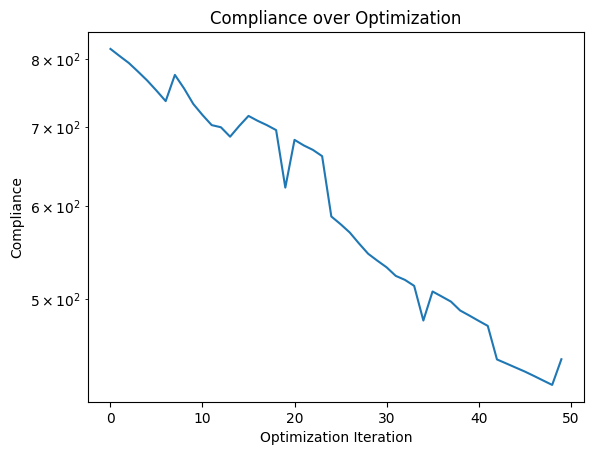

In [103]:
plt.plot(loss_hist)
plt.yscale("log") 
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization");

We can also trace the y coordinates of the vertices over the optimization steps. This gives us an idea of how the design variables are changing during the optimization process.

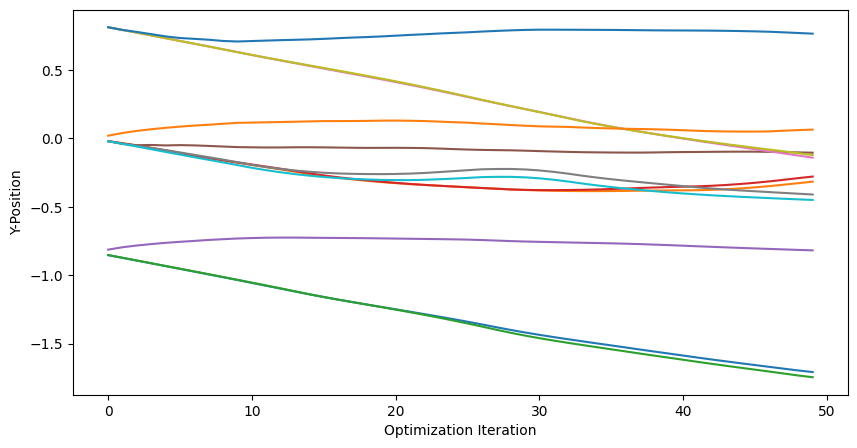

In [104]:
param_hist_tensor = jnp.array(params_hist)

plt.figure(figsize=(10, 5))

for chain in range(n_chains):
    for edge in range(n_edges_per_chain + 1):
        plt.plot(
            param_hist_tensor[:, chain, edge, 1].T, label=f"Chain {chain}, Edge {edge} y"
        )
        plt.plot(
            param_hist_tensor[:, chain, edge, 2].T, label=f"Chain {chain}, Edge {edge} z"
        )

plt.xlabel("Optimization Iteration")
plt.ylabel("Y-Position");

## Step 3: Visualize results

After optimization, the structure has been adjusted to assume a more stable configuration under the given load. The design variables have been tuned to achieve this goal, reducing the compliance of the structure from around 10,000 to about 200.

Here is the final optimized structure:

We generate a video of the optimization process to visualize how the structure evolves over time.

In [105]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

ims = []
for params in params_hist:
    sdf = apply_tesseract(
        design_tess,
        {
            "bar_params": params,
            "bar_radius": bar_radius,
            "Lx": Lx,
            "Ly": Ly,
            "Lz": Lz,
            "Nx": Nx,
            "Ny": Ny,
            "Nz": Nz,
            "epsilon": 1e-3,
        },
    )["sdf"]

    rho = sdf_to_rho(sdf)

    im = plt.imshow(
        rho[:, :, Nz // 2].T, origin="lower", cmap="viridis", vmin=0, vmax=1
    )
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=True, repeat_delay=2)
plt.close(fig)

ani.save("rho_optim.gif", writer="pillow", fps=10)

In [106]:
from IPython.display import HTML

HTML(ani.to_jshtml(fps=10, embed_frames=True))

FileNotFoundError: [Errno 2] No such file or directory: 'img/mesh_optim_000.png'

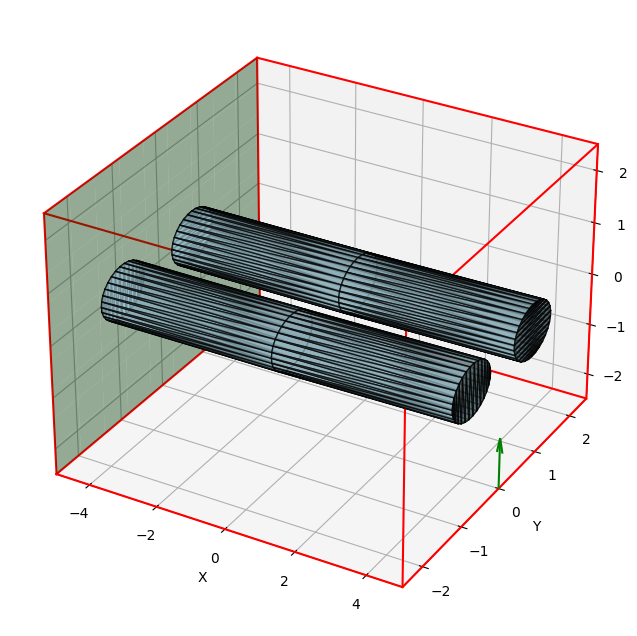

In [107]:
# lets visualize the 3d meshes over the optimization
for i, params in enumerate(params_hist):
    design_out = design_tess.apply(
        {
            "bar_params": params,
            "bar_radius": bar_radius,
            "Lx": Lx,
            "Ly": Ly,
            "Lz": Lz,
            "Nx": Nx,
            "Ny": Ny,
            "Nz": Nz,
            "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
        }
    )
    surface_mesh = design_out["mesh"]

    num_vertices = surface_mesh["n_points"]
    num_faces = surface_mesh["n_faces"]

    points = surface_mesh["points"][:num_vertices]
    faces = surface_mesh["faces"][:num_faces]

    mesh = {
        "points": points,
        "faces": faces,
    }

    plot_mesh(mesh, save_path=f"img/mesh_optim_{i:03d}.png")